# M2177.003100 Deep Learning <br> Assignment #4 Implementing Variational AutoEncoder - part1 MNIST data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Chaehun Shin, September

In this notebook, you will learn how to implement Variational AutoEncoder(VAEs). <br>
The goal here is to build VAEs that draw a digit(MNIST data). <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #1:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).
- [4] Doersch, Carl. "Tutorial on variational autoencoders." arXiv preprint arXiv:1606.05908 (2016).
- [5] Kingma, Diederik P., and Max Welling. "An Introduction to Variational Autoencoders." arXiv preprint arXiv:1906.02691 (2019).

## 0. Download and load MNIST datasets
The MNIST dataset will be downloaded into the 'data' directory. If you want to change the directory where the data is saved, change mnist_data_dir with where you want. <br>

In [9]:
from download import *
import os
from utils import load_mnist
mnist_data_dir = './data'
prepare_data_dir(mnist_data_dir)
download_mnist(mnist_data_dir)
data_array , data_y = load_mnist(os.path.join(mnist_data_dir,'mnist'))
print(data_array.shape)
print(data_y.shape)

Found MNIST - skip
(70000, 28, 28, 1)
(70000, 10)


## <a name="1"></a> 1. Build a network

In this section, you will implement neural networks for (1)encoder $q_\phi(z \mid x)$ to encode latent variable distribution from the image of digits (2)decoder $p_\theta(x \mid z)$ to reconstruct the image of digits from the sample of latent variable distribution. You can use some function in *ops.py* or you can make it as you want. Just write the code in whatever way you find most clear.

In [10]:
from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

It is time for an encoder. It takes img_data, img_dim(should be 28\*28\*1=784 here), latent_dim(dimension of the z). It should return the latent variable distribution with the dimension of latent_dim. <br>
Because we model the latent variable distribution as multivariate Gaussian, we can make the distribution with only mean and covariance matrix. Also as we model each latent variable as independent, covariance matrix becomes a diagonal matrix and we need only (latent_dim) number elements. so we make outputs as 2 (latent_dim) dimension vectors from encoder function with neural network. I recommend to use logvar not variance itself because of scalability.

<img src='./pictures/encoder.png'>

Maybe you can use two neural networks for mean and logvar vectors. However it is recommended to use only one neural network with two last branches.<br> 
For example, if you use 5 layer networks, first 4 layers are shared and there are 2 5th layer each corresponding to mean and logvar.

In [69]:
def encoder(img_data, img_dim=784, latent_dim=10, reuse=False):
    with tf.variable_scope('enc', reuse=reuse):
        ### ToDo ###
        flatten = tf.contrib.layers.flatten(img_data)
        h1 = tf.layers.dense(flatten, units=512, activation='relu')
        h2 = tf.layers.dense(h1, units=latent_dim*2)
        mean = h2[:, :latent_dim]
        logvar = h2[:, latent_dim:]
        
        return mean, logvar

Now, it's time for a decoder model. It takes sample of the latent variable distribution(z), latent_dim(dimension of the latent variable), and img_dim(28\*28\*1 here). It should return the reconstruction of the original image as x_hat. <br>
Decoder models the likelihood distributions and in here, we model each pixel as Bernoulli distribution(So we use binary cross entropy as loss function). So **you should use the sigmoid function to make the output as probability in [0, 1]**

<img src='./pictures/decoder.png'>

Note that you should define Tensorflow Variables within the variable scope again.

In [91]:
def decoder(z, latent_dim=10, img_dim=784, reuse=False):
    with tf.variable_scope('dec', reuse=reuse):
        ### ToDo ###
        h1 = tf.layers.dense(z, units=512, activation='relu')
        decoder_output = tf.layers.dense(h1, units=img_dim, activation='sigmoid')
        
        return decoder_output

## <a name="2"></a> 2. Build a main part and train it

In this section, you will implement the main part. You should define the loss function and reparameterization trick (TODO part). Then run the code and check the model reconstructs a digit.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test/vae_mnist' directory that resulting image will be saved in. You can change the directory as you want.

Also, you can change all other hyperparameters such as learning rate, batch size. But be sure to define **batch size bigger than 16**.(Because, we visualize 16 images per batch in training time.)

In [58]:
from utils import load_mnist
from utils import save_images
from utils import show_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 
import os

learning_rate = 1e-4
batch_size = 128
EPOCH = 1000
loss_step    = 500
display_step = 2500
latent_channel=16
img_channel = 1
output_size = 28
sample_dir = 'samples_for_test/vae_mnist'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Because sampling can't be differentiated, it needs some tricks called as reparameterization trick.<br>
First, epsilon is sampled from unit Gaussian distribution with latent_dim. Then, scale and shift it by using mean and logvar.<br>
Because sampling is out of graph, gradient can be flowed through all paths and encoder/decoder are trained end-to-end.

<img src='./pictures/reparameterization.png'>
Left image is original version and right image is representation by using reparameterization trick.

Results are visualized in order of original image, reconstructed image, generated image from the left.

In [106]:
tf.reset_default_graph()

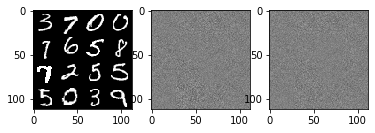

<Epoch:1/1000, Step:500/545>total_loss: 183.0277, kl_loss: 17.7723, recon_loss: 165.2554
<Epoch:2/1000, Step:455/545>total_loss: 155.8436, kl_loss: 20.3315, recon_loss: 135.5121
<Epoch:3/1000, Step:410/545>total_loss: 146.4350, kl_loss: 20.9524, recon_loss: 125.4826
<Epoch:4/1000, Step:365/545>total_loss: 140.0807, kl_loss: 21.3573, recon_loss: 118.7234
<Epoch:5/1000, Step:320/545>total_loss: 134.3530, kl_loss: 21.3599, recon_loss: 112.9931


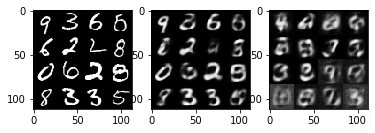

<Epoch:6/1000, Step:275/545>total_loss: 130.0403, kl_loss: 22.0737, recon_loss: 107.9666
<Epoch:7/1000, Step:230/545>total_loss: 121.2345, kl_loss: 21.3246, recon_loss: 99.9099
<Epoch:8/1000, Step:185/545>total_loss: 123.8668, kl_loss: 22.5194, recon_loss: 101.3473
<Epoch:9/1000, Step:140/545>total_loss: 125.5983, kl_loss: 22.8689, recon_loss: 102.7294
<Epoch:10/1000, Step:095/545>total_loss: 119.9728, kl_loss: 22.3820, recon_loss: 97.5908


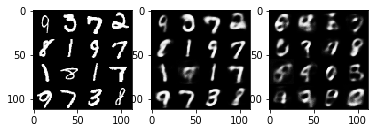

<Epoch:11/1000, Step:050/545>total_loss: 122.0265, kl_loss: 22.4487, recon_loss: 99.5778
<Epoch:12/1000, Step:005/545>total_loss: 119.1849, kl_loss: 22.4711, recon_loss: 96.7138
<Epoch:12/1000, Step:505/545>total_loss: 117.6510, kl_loss: 22.4704, recon_loss: 95.1806
<Epoch:13/1000, Step:460/545>total_loss: 122.2637, kl_loss: 22.5038, recon_loss: 99.7599
<Epoch:14/1000, Step:415/545>total_loss: 115.4575, kl_loss: 22.8747, recon_loss: 92.5829


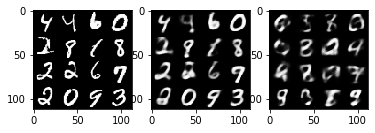

<Epoch:15/1000, Step:370/545>total_loss: 113.0196, kl_loss: 22.7372, recon_loss: 90.2824
<Epoch:16/1000, Step:325/545>total_loss: 110.7297, kl_loss: 22.3182, recon_loss: 88.4114
<Epoch:17/1000, Step:280/545>total_loss: 115.3333, kl_loss: 22.6529, recon_loss: 92.6804
<Epoch:18/1000, Step:235/545>total_loss: 111.1951, kl_loss: 22.6398, recon_loss: 88.5553
<Epoch:19/1000, Step:190/545>total_loss: 106.5270, kl_loss: 22.5705, recon_loss: 83.9565


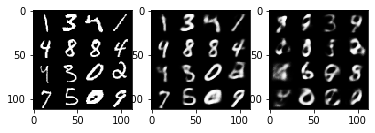

<Epoch:20/1000, Step:145/545>total_loss: 113.0601, kl_loss: 23.2128, recon_loss: 89.8473
<Epoch:21/1000, Step:100/545>total_loss: 113.2378, kl_loss: 22.5561, recon_loss: 90.6816
<Epoch:22/1000, Step:055/545>total_loss: 113.0048, kl_loss: 22.6975, recon_loss: 90.3073
<Epoch:23/1000, Step:010/545>total_loss: 111.1780, kl_loss: 23.3744, recon_loss: 87.8036
<Epoch:23/1000, Step:510/545>total_loss: 109.5925, kl_loss: 22.7363, recon_loss: 86.8562


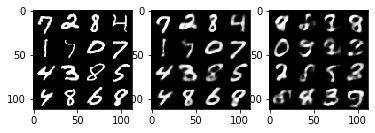

<Epoch:24/1000, Step:465/545>total_loss: 110.7942, kl_loss: 22.8220, recon_loss: 87.9722
<Epoch:25/1000, Step:420/545>total_loss: 110.1282, kl_loss: 22.5313, recon_loss: 87.5969
<Epoch:26/1000, Step:375/545>total_loss: 110.2803, kl_loss: 23.2683, recon_loss: 87.0120
<Epoch:27/1000, Step:330/545>total_loss: 110.8419, kl_loss: 22.9386, recon_loss: 87.9033
<Epoch:28/1000, Step:285/545>total_loss: 106.6932, kl_loss: 22.4999, recon_loss: 84.1933


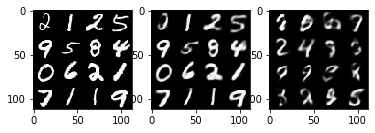

<Epoch:29/1000, Step:240/545>total_loss: 106.6337, kl_loss: 23.1323, recon_loss: 83.5014
<Epoch:30/1000, Step:195/545>total_loss: 106.6567, kl_loss: 23.4152, recon_loss: 83.2415
<Epoch:31/1000, Step:150/545>total_loss: 111.3209, kl_loss: 23.7451, recon_loss: 87.5758
<Epoch:32/1000, Step:105/545>total_loss: 110.1353, kl_loss: 23.1444, recon_loss: 86.9908
<Epoch:33/1000, Step:060/545>total_loss: 107.5260, kl_loss: 23.5243, recon_loss: 84.0017


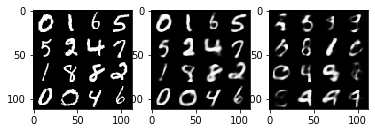

<Epoch:34/1000, Step:015/545>total_loss: 102.1244, kl_loss: 22.7934, recon_loss: 79.3310
<Epoch:34/1000, Step:515/545>total_loss: 104.5342, kl_loss: 22.9953, recon_loss: 81.5389
<Epoch:35/1000, Step:470/545>total_loss: 108.9741, kl_loss: 23.1107, recon_loss: 85.8633
<Epoch:36/1000, Step:425/545>total_loss: 110.5402, kl_loss: 23.6463, recon_loss: 86.8939
<Epoch:37/1000, Step:380/545>total_loss: 108.9851, kl_loss: 23.9675, recon_loss: 85.0177


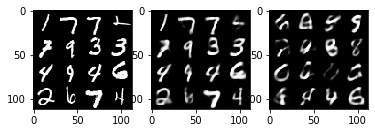

<Epoch:38/1000, Step:335/545>total_loss: 104.3835, kl_loss: 22.9213, recon_loss: 81.4621
<Epoch:39/1000, Step:290/545>total_loss: 106.3230, kl_loss: 23.4704, recon_loss: 82.8526
<Epoch:40/1000, Step:245/545>total_loss: 107.0726, kl_loss: 23.3873, recon_loss: 83.6854
<Epoch:41/1000, Step:200/545>total_loss: 109.1616, kl_loss: 23.4108, recon_loss: 85.7508
<Epoch:42/1000, Step:155/545>total_loss: 110.9583, kl_loss: 23.7996, recon_loss: 87.1588


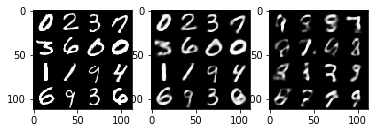

<Epoch:43/1000, Step:110/545>total_loss: 108.5710, kl_loss: 23.0936, recon_loss: 85.4774
<Epoch:44/1000, Step:065/545>total_loss: 107.9932, kl_loss: 24.0999, recon_loss: 83.8932
<Epoch:45/1000, Step:020/545>total_loss: 108.3973, kl_loss: 23.9643, recon_loss: 84.4330
<Epoch:45/1000, Step:520/545>total_loss: 105.0934, kl_loss: 23.1690, recon_loss: 81.9245
<Epoch:46/1000, Step:475/545>total_loss: 104.3809, kl_loss: 23.2643, recon_loss: 81.1167


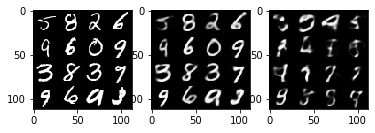

<Epoch:47/1000, Step:430/545>total_loss: 102.8052, kl_loss: 23.4567, recon_loss: 79.3486
<Epoch:48/1000, Step:385/545>total_loss: 102.8464, kl_loss: 23.7229, recon_loss: 79.1235
<Epoch:49/1000, Step:340/545>total_loss: 107.8090, kl_loss: 23.6783, recon_loss: 84.1307
<Epoch:50/1000, Step:295/545>total_loss: 104.8082, kl_loss: 23.3863, recon_loss: 81.4219
<Epoch:51/1000, Step:250/545>total_loss: 106.0683, kl_loss: 23.6023, recon_loss: 82.4660


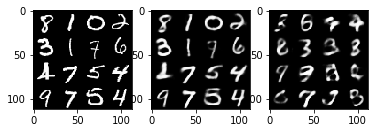

<Epoch:52/1000, Step:205/545>total_loss: 107.2055, kl_loss: 23.5309, recon_loss: 83.6746
<Epoch:53/1000, Step:160/545>total_loss: 106.5716, kl_loss: 23.8714, recon_loss: 82.7003
<Epoch:54/1000, Step:115/545>total_loss: 105.5567, kl_loss: 23.3625, recon_loss: 82.1942
<Epoch:55/1000, Step:070/545>total_loss: 103.7295, kl_loss: 23.7117, recon_loss: 80.0178
<Epoch:56/1000, Step:025/545>total_loss: 107.0386, kl_loss: 23.8108, recon_loss: 83.2278


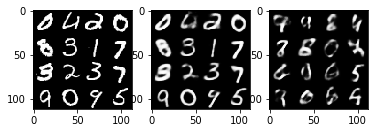

<Epoch:56/1000, Step:525/545>total_loss: 102.6061, kl_loss: 23.3446, recon_loss: 79.2615
<Epoch:57/1000, Step:480/545>total_loss: 106.6801, kl_loss: 23.2215, recon_loss: 83.4586
<Epoch:58/1000, Step:435/545>total_loss: 104.7494, kl_loss: 23.1814, recon_loss: 81.5679
<Epoch:59/1000, Step:390/545>total_loss: 104.1345, kl_loss: 23.3092, recon_loss: 80.8254
<Epoch:60/1000, Step:345/545>total_loss: 107.5745, kl_loss: 23.3363, recon_loss: 84.2382


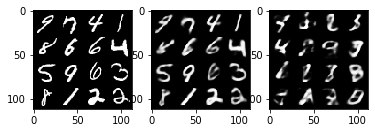

<Epoch:61/1000, Step:300/545>total_loss: 105.2004, kl_loss: 23.7307, recon_loss: 81.4697
<Epoch:62/1000, Step:255/545>total_loss: 102.1517, kl_loss: 23.0440, recon_loss: 79.1077
<Epoch:63/1000, Step:210/545>total_loss: 107.3445, kl_loss: 24.1474, recon_loss: 83.1970
<Epoch:64/1000, Step:165/545>total_loss: 106.0754, kl_loss: 23.8560, recon_loss: 82.2194
<Epoch:65/1000, Step:120/545>total_loss: 103.9485, kl_loss: 23.5318, recon_loss: 80.4168


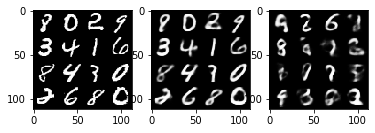

<Epoch:66/1000, Step:075/545>total_loss: 104.1904, kl_loss: 23.7078, recon_loss: 80.4827
<Epoch:67/1000, Step:030/545>total_loss: 101.5683, kl_loss: 23.2160, recon_loss: 78.3523
<Epoch:67/1000, Step:530/545>total_loss: 106.3891, kl_loss: 23.7440, recon_loss: 82.6451
<Epoch:68/1000, Step:485/545>total_loss: 104.3727, kl_loss: 23.4832, recon_loss: 80.8895
<Epoch:69/1000, Step:440/545>total_loss: 98.6075, kl_loss: 23.0505, recon_loss: 75.5570


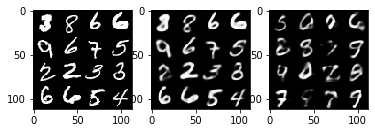

<Epoch:70/1000, Step:395/545>total_loss: 106.6652, kl_loss: 24.4961, recon_loss: 82.1691
<Epoch:71/1000, Step:350/545>total_loss: 103.4803, kl_loss: 23.5352, recon_loss: 79.9451
<Epoch:72/1000, Step:305/545>total_loss: 105.2728, kl_loss: 23.9928, recon_loss: 81.2799
<Epoch:73/1000, Step:260/545>total_loss: 109.4965, kl_loss: 24.1299, recon_loss: 85.3666
<Epoch:74/1000, Step:215/545>total_loss: 103.3314, kl_loss: 23.8386, recon_loss: 79.4928


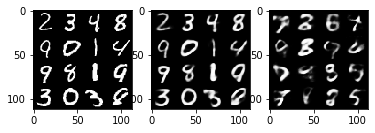

<Epoch:75/1000, Step:170/545>total_loss: 106.6861, kl_loss: 23.6751, recon_loss: 83.0111
<Epoch:76/1000, Step:125/545>total_loss: 104.8554, kl_loss: 24.1560, recon_loss: 80.6994
<Epoch:77/1000, Step:080/545>total_loss: 100.5484, kl_loss: 23.5606, recon_loss: 76.9877
<Epoch:78/1000, Step:035/545>total_loss: 105.9852, kl_loss: 24.0263, recon_loss: 81.9590
<Epoch:78/1000, Step:535/545>total_loss: 105.2828, kl_loss: 24.0563, recon_loss: 81.2265


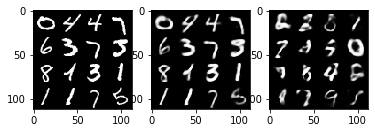

<Epoch:79/1000, Step:490/545>total_loss: 101.4200, kl_loss: 23.0922, recon_loss: 78.3278
<Epoch:80/1000, Step:445/545>total_loss: 108.0160, kl_loss: 24.3045, recon_loss: 83.7115
<Epoch:81/1000, Step:400/545>total_loss: 101.7904, kl_loss: 23.5394, recon_loss: 78.2510
<Epoch:82/1000, Step:355/545>total_loss: 108.0554, kl_loss: 24.2227, recon_loss: 83.8327
<Epoch:83/1000, Step:310/545>total_loss: 103.2702, kl_loss: 23.4714, recon_loss: 79.7988


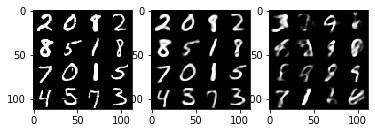

<Epoch:84/1000, Step:265/545>total_loss: 107.0198, kl_loss: 24.3991, recon_loss: 82.6207
<Epoch:85/1000, Step:220/545>total_loss: 100.2134, kl_loss: 23.3534, recon_loss: 76.8599
<Epoch:86/1000, Step:175/545>total_loss: 101.0205, kl_loss: 23.9831, recon_loss: 77.0374
<Epoch:87/1000, Step:130/545>total_loss: 99.3839, kl_loss: 23.5480, recon_loss: 75.8360
<Epoch:88/1000, Step:085/545>total_loss: 100.5842, kl_loss: 23.4431, recon_loss: 77.1412


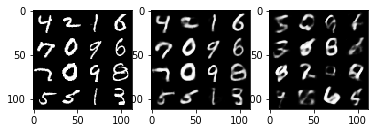

<Epoch:89/1000, Step:040/545>total_loss: 105.3579, kl_loss: 24.4118, recon_loss: 80.9461
<Epoch:89/1000, Step:540/545>total_loss: 102.7298, kl_loss: 23.9069, recon_loss: 78.8229
<Epoch:90/1000, Step:495/545>total_loss: 100.2642, kl_loss: 23.6979, recon_loss: 76.5663
<Epoch:91/1000, Step:450/545>total_loss: 107.8146, kl_loss: 24.8611, recon_loss: 82.9535
<Epoch:92/1000, Step:405/545>total_loss: 97.8713, kl_loss: 23.5222, recon_loss: 74.3491


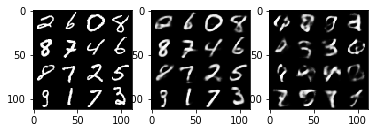

<Epoch:93/1000, Step:360/545>total_loss: 98.2072, kl_loss: 23.4271, recon_loss: 74.7800
<Epoch:94/1000, Step:315/545>total_loss: 103.6450, kl_loss: 24.4803, recon_loss: 79.1647
<Epoch:95/1000, Step:270/545>total_loss: 100.0621, kl_loss: 23.3637, recon_loss: 76.6984
<Epoch:96/1000, Step:225/545>total_loss: 100.2751, kl_loss: 23.7177, recon_loss: 76.5574
<Epoch:97/1000, Step:180/545>total_loss: 106.3825, kl_loss: 24.3543, recon_loss: 82.0282


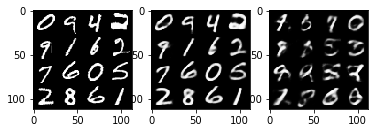

<Epoch:98/1000, Step:135/545>total_loss: 102.1868, kl_loss: 23.8276, recon_loss: 78.3592
<Epoch:99/1000, Step:090/545>total_loss: 106.6602, kl_loss: 24.5260, recon_loss: 82.1341
<Epoch:100/1000, Step:045/545>total_loss: 104.7669, kl_loss: 24.2761, recon_loss: 80.4908
<Epoch:100/1000, Step:545/545>total_loss: 105.6233, kl_loss: 23.9844, recon_loss: 81.6388
<Epoch:101/1000, Step:500/545>total_loss: 106.8709, kl_loss: 24.4818, recon_loss: 82.3892


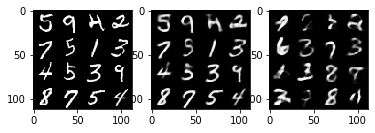

<Epoch:102/1000, Step:455/545>total_loss: 103.8287, kl_loss: 24.1962, recon_loss: 79.6325
<Epoch:103/1000, Step:410/545>total_loss: 105.8015, kl_loss: 24.3624, recon_loss: 81.4391
<Epoch:104/1000, Step:365/545>total_loss: 102.8731, kl_loss: 24.3431, recon_loss: 78.5300
<Epoch:105/1000, Step:320/545>total_loss: 97.8664, kl_loss: 23.6964, recon_loss: 74.1700
<Epoch:106/1000, Step:275/545>total_loss: 104.1240, kl_loss: 24.2348, recon_loss: 79.8893


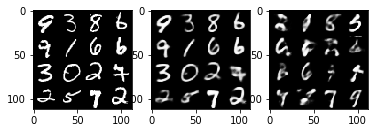

<Epoch:107/1000, Step:230/545>total_loss: 102.9373, kl_loss: 24.3310, recon_loss: 78.6064
<Epoch:108/1000, Step:185/545>total_loss: 106.0029, kl_loss: 24.2436, recon_loss: 81.7593
<Epoch:109/1000, Step:140/545>total_loss: 101.6783, kl_loss: 23.9198, recon_loss: 77.7585
<Epoch:110/1000, Step:095/545>total_loss: 103.4329, kl_loss: 23.5427, recon_loss: 79.8902
<Epoch:111/1000, Step:050/545>total_loss: 103.7917, kl_loss: 24.1106, recon_loss: 79.6811


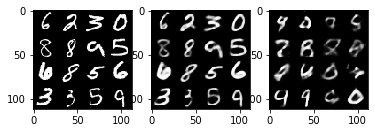

<Epoch:112/1000, Step:005/545>total_loss: 102.4614, kl_loss: 24.0202, recon_loss: 78.4411
<Epoch:112/1000, Step:505/545>total_loss: 101.2322, kl_loss: 23.8670, recon_loss: 77.3652
<Epoch:113/1000, Step:460/545>total_loss: 104.8994, kl_loss: 23.6747, recon_loss: 81.2246
<Epoch:114/1000, Step:415/545>total_loss: 102.5657, kl_loss: 23.9810, recon_loss: 78.5847
<Epoch:115/1000, Step:370/545>total_loss: 103.3584, kl_loss: 23.8621, recon_loss: 79.4962


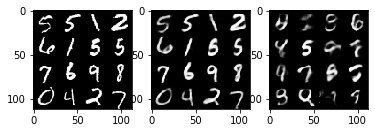

<Epoch:116/1000, Step:325/545>total_loss: 101.6740, kl_loss: 23.7980, recon_loss: 77.8761
<Epoch:117/1000, Step:280/545>total_loss: 104.1659, kl_loss: 23.8696, recon_loss: 80.2964
<Epoch:118/1000, Step:235/545>total_loss: 101.0376, kl_loss: 23.8201, recon_loss: 77.2175
<Epoch:119/1000, Step:190/545>total_loss: 100.6792, kl_loss: 23.6129, recon_loss: 77.0663
<Epoch:120/1000, Step:145/545>total_loss: 103.0781, kl_loss: 24.1062, recon_loss: 78.9719


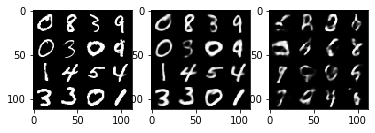

<Epoch:121/1000, Step:100/545>total_loss: 98.4772, kl_loss: 23.3925, recon_loss: 75.0846
<Epoch:122/1000, Step:055/545>total_loss: 102.9048, kl_loss: 23.9823, recon_loss: 78.9225
<Epoch:123/1000, Step:010/545>total_loss: 99.9131, kl_loss: 23.9056, recon_loss: 76.0075
<Epoch:123/1000, Step:510/545>total_loss: 101.9756, kl_loss: 24.4209, recon_loss: 77.5546
<Epoch:124/1000, Step:465/545>total_loss: 97.6777, kl_loss: 23.7612, recon_loss: 73.9165


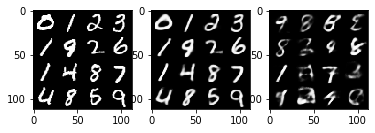

<Epoch:125/1000, Step:420/545>total_loss: 99.5341, kl_loss: 23.7675, recon_loss: 75.7666
<Epoch:126/1000, Step:375/545>total_loss: 105.6419, kl_loss: 24.4256, recon_loss: 81.2163
<Epoch:127/1000, Step:330/545>total_loss: 99.5404, kl_loss: 24.3354, recon_loss: 75.2051
<Epoch:128/1000, Step:285/545>total_loss: 98.2637, kl_loss: 23.3694, recon_loss: 74.8943
<Epoch:129/1000, Step:240/545>total_loss: 100.5653, kl_loss: 24.0867, recon_loss: 76.4786


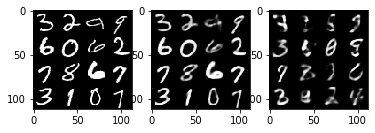

<Epoch:130/1000, Step:195/545>total_loss: 99.5354, kl_loss: 23.8233, recon_loss: 75.7121
<Epoch:131/1000, Step:150/545>total_loss: 101.3017, kl_loss: 23.4663, recon_loss: 77.8353
<Epoch:132/1000, Step:105/545>total_loss: 100.2732, kl_loss: 23.6531, recon_loss: 76.6201
<Epoch:133/1000, Step:060/545>total_loss: 102.4662, kl_loss: 24.0634, recon_loss: 78.4028
<Epoch:134/1000, Step:015/545>total_loss: 104.4911, kl_loss: 24.2793, recon_loss: 80.2118


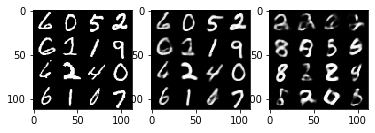

<Epoch:134/1000, Step:515/545>total_loss: 97.5577, kl_loss: 23.3072, recon_loss: 74.2505
<Epoch:135/1000, Step:470/545>total_loss: 104.0758, kl_loss: 24.1874, recon_loss: 79.8884
<Epoch:136/1000, Step:425/545>total_loss: 103.7251, kl_loss: 24.4374, recon_loss: 79.2877
<Epoch:137/1000, Step:380/545>total_loss: 102.9298, kl_loss: 24.2085, recon_loss: 78.7213
<Epoch:138/1000, Step:335/545>total_loss: 103.6385, kl_loss: 24.5862, recon_loss: 79.0524


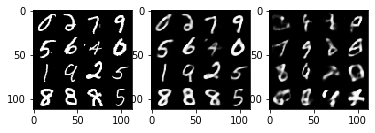

<Epoch:139/1000, Step:290/545>total_loss: 103.6557, kl_loss: 23.5436, recon_loss: 80.1121
<Epoch:140/1000, Step:245/545>total_loss: 104.7691, kl_loss: 23.7702, recon_loss: 80.9989
<Epoch:141/1000, Step:200/545>total_loss: 100.5830, kl_loss: 24.1054, recon_loss: 76.4776
<Epoch:142/1000, Step:155/545>total_loss: 102.6932, kl_loss: 23.7621, recon_loss: 78.9311
<Epoch:143/1000, Step:110/545>total_loss: 99.3444, kl_loss: 23.8629, recon_loss: 75.4815


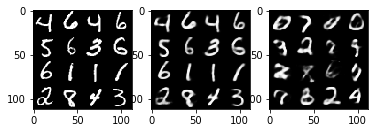

<Epoch:144/1000, Step:065/545>total_loss: 104.8301, kl_loss: 24.1353, recon_loss: 80.6948
<Epoch:145/1000, Step:020/545>total_loss: 101.6852, kl_loss: 24.1984, recon_loss: 77.4869
<Epoch:145/1000, Step:520/545>total_loss: 101.6335, kl_loss: 24.3365, recon_loss: 77.2970
<Epoch:146/1000, Step:475/545>total_loss: 100.5433, kl_loss: 24.3591, recon_loss: 76.1842
<Epoch:147/1000, Step:430/545>total_loss: 98.6062, kl_loss: 23.8545, recon_loss: 74.7517


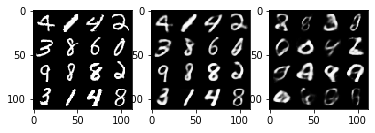

<Epoch:148/1000, Step:385/545>total_loss: 105.7352, kl_loss: 24.5134, recon_loss: 81.2217
<Epoch:149/1000, Step:340/545>total_loss: 103.0452, kl_loss: 24.2265, recon_loss: 78.8187
<Epoch:150/1000, Step:295/545>total_loss: 100.2229, kl_loss: 23.9936, recon_loss: 76.2292
<Epoch:151/1000, Step:250/545>total_loss: 100.7734, kl_loss: 23.8876, recon_loss: 76.8858
<Epoch:152/1000, Step:205/545>total_loss: 101.6648, kl_loss: 24.4121, recon_loss: 77.2526


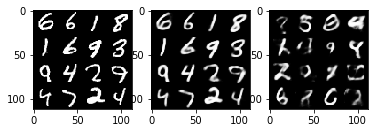

<Epoch:153/1000, Step:160/545>total_loss: 101.8130, kl_loss: 23.8954, recon_loss: 77.9176
<Epoch:154/1000, Step:115/545>total_loss: 100.4220, kl_loss: 23.9547, recon_loss: 76.4674
<Epoch:155/1000, Step:070/545>total_loss: 99.4816, kl_loss: 23.9223, recon_loss: 75.5592
<Epoch:156/1000, Step:025/545>total_loss: 101.8487, kl_loss: 23.8682, recon_loss: 77.9805
<Epoch:156/1000, Step:525/545>total_loss: 99.0126, kl_loss: 23.9866, recon_loss: 75.0259


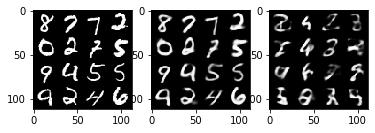

<Epoch:157/1000, Step:480/545>total_loss: 104.9992, kl_loss: 24.4363, recon_loss: 80.5629
<Epoch:158/1000, Step:435/545>total_loss: 99.8830, kl_loss: 24.2681, recon_loss: 75.6149
<Epoch:159/1000, Step:390/545>total_loss: 100.6604, kl_loss: 23.7461, recon_loss: 76.9143
<Epoch:160/1000, Step:345/545>total_loss: 100.3557, kl_loss: 23.7205, recon_loss: 76.6352
<Epoch:161/1000, Step:300/545>total_loss: 99.2027, kl_loss: 23.5940, recon_loss: 75.6087


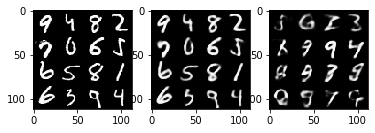

<Epoch:162/1000, Step:255/545>total_loss: 104.8412, kl_loss: 24.7921, recon_loss: 80.0491
<Epoch:163/1000, Step:210/545>total_loss: 95.6104, kl_loss: 23.5453, recon_loss: 72.0651
<Epoch:164/1000, Step:165/545>total_loss: 103.3358, kl_loss: 24.1920, recon_loss: 79.1438
<Epoch:165/1000, Step:120/545>total_loss: 106.3008, kl_loss: 24.7401, recon_loss: 81.5607
<Epoch:166/1000, Step:075/545>total_loss: 98.4534, kl_loss: 23.6457, recon_loss: 74.8078


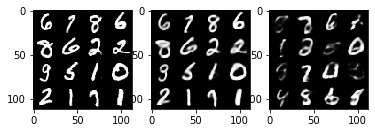

<Epoch:167/1000, Step:030/545>total_loss: 102.0799, kl_loss: 24.3086, recon_loss: 77.7713
<Epoch:167/1000, Step:530/545>total_loss: 99.6975, kl_loss: 23.9226, recon_loss: 75.7749
<Epoch:168/1000, Step:485/545>total_loss: 101.8284, kl_loss: 24.1323, recon_loss: 77.6962
<Epoch:169/1000, Step:440/545>total_loss: 104.2637, kl_loss: 24.0917, recon_loss: 80.1720
<Epoch:170/1000, Step:395/545>total_loss: 109.1083, kl_loss: 24.9816, recon_loss: 84.1267


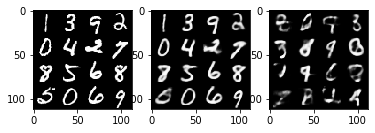

<Epoch:171/1000, Step:350/545>total_loss: 101.6973, kl_loss: 24.1474, recon_loss: 77.5500
<Epoch:172/1000, Step:305/545>total_loss: 103.0120, kl_loss: 24.5312, recon_loss: 78.4809
<Epoch:173/1000, Step:260/545>total_loss: 100.3055, kl_loss: 24.4393, recon_loss: 75.8662
<Epoch:174/1000, Step:215/545>total_loss: 99.8429, kl_loss: 23.6991, recon_loss: 76.1438
<Epoch:175/1000, Step:170/545>total_loss: 101.0836, kl_loss: 23.6690, recon_loss: 77.4147


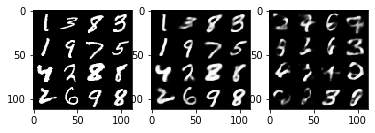

<Epoch:176/1000, Step:125/545>total_loss: 100.0109, kl_loss: 24.5192, recon_loss: 75.4917
<Epoch:177/1000, Step:080/545>total_loss: 103.0845, kl_loss: 24.3537, recon_loss: 78.7308
<Epoch:178/1000, Step:035/545>total_loss: 103.0097, kl_loss: 24.6622, recon_loss: 78.3475
<Epoch:178/1000, Step:535/545>total_loss: 99.2856, kl_loss: 24.0572, recon_loss: 75.2284
<Epoch:179/1000, Step:490/545>total_loss: 101.8854, kl_loss: 23.8953, recon_loss: 77.9901


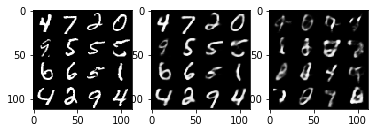

<Epoch:180/1000, Step:445/545>total_loss: 101.0151, kl_loss: 24.2700, recon_loss: 76.7451
<Epoch:181/1000, Step:400/545>total_loss: 101.7873, kl_loss: 24.0978, recon_loss: 77.6895
<Epoch:182/1000, Step:355/545>total_loss: 98.6282, kl_loss: 23.5651, recon_loss: 75.0630
<Epoch:183/1000, Step:310/545>total_loss: 102.6486, kl_loss: 24.3312, recon_loss: 78.3173
<Epoch:184/1000, Step:265/545>total_loss: 98.7477, kl_loss: 23.9247, recon_loss: 74.8230


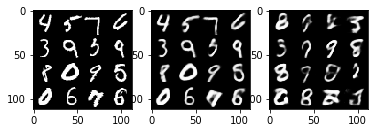

<Epoch:185/1000, Step:220/545>total_loss: 104.3914, kl_loss: 24.8909, recon_loss: 79.5005
<Epoch:186/1000, Step:175/545>total_loss: 99.3790, kl_loss: 23.6654, recon_loss: 75.7136
<Epoch:187/1000, Step:130/545>total_loss: 100.0675, kl_loss: 23.9677, recon_loss: 76.0997
<Epoch:188/1000, Step:085/545>total_loss: 99.5719, kl_loss: 23.5108, recon_loss: 76.0611
<Epoch:189/1000, Step:040/545>total_loss: 99.5713, kl_loss: 23.7759, recon_loss: 75.7954


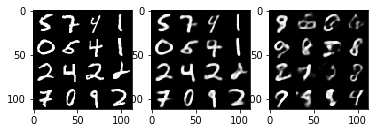

<Epoch:189/1000, Step:540/545>total_loss: 98.6380, kl_loss: 23.8503, recon_loss: 74.7877
<Epoch:190/1000, Step:495/545>total_loss: 101.5360, kl_loss: 24.1395, recon_loss: 77.3965
<Epoch:191/1000, Step:450/545>total_loss: 99.6147, kl_loss: 23.9768, recon_loss: 75.6379
<Epoch:192/1000, Step:405/545>total_loss: 102.4400, kl_loss: 24.4403, recon_loss: 77.9997
<Epoch:193/1000, Step:360/545>total_loss: 102.6435, kl_loss: 24.1349, recon_loss: 78.5086


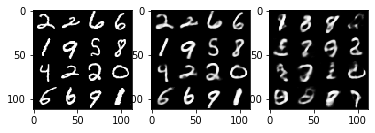

<Epoch:194/1000, Step:315/545>total_loss: 105.3853, kl_loss: 24.9265, recon_loss: 80.4588
<Epoch:195/1000, Step:270/545>total_loss: 101.5467, kl_loss: 24.0187, recon_loss: 77.5281
<Epoch:196/1000, Step:225/545>total_loss: 100.3547, kl_loss: 23.8230, recon_loss: 76.5316
<Epoch:197/1000, Step:180/545>total_loss: 101.1026, kl_loss: 24.0711, recon_loss: 77.0315
<Epoch:198/1000, Step:135/545>total_loss: 104.8883, kl_loss: 24.6020, recon_loss: 80.2863


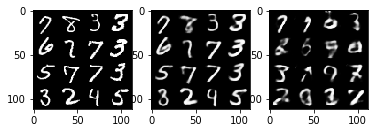

<Epoch:199/1000, Step:090/545>total_loss: 102.5127, kl_loss: 24.5232, recon_loss: 77.9895
<Epoch:200/1000, Step:045/545>total_loss: 99.8369, kl_loss: 23.7363, recon_loss: 76.1006
<Epoch:200/1000, Step:545/545>total_loss: 100.2348, kl_loss: 24.4265, recon_loss: 75.8082
<Epoch:201/1000, Step:500/545>total_loss: 101.2687, kl_loss: 24.3337, recon_loss: 76.9350
<Epoch:202/1000, Step:455/545>total_loss: 99.0918, kl_loss: 23.8631, recon_loss: 75.2286


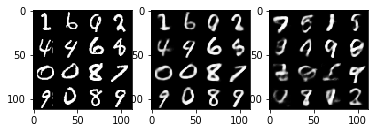

<Epoch:203/1000, Step:410/545>total_loss: 104.2694, kl_loss: 24.5747, recon_loss: 79.6947
<Epoch:204/1000, Step:365/545>total_loss: 98.8423, kl_loss: 24.1332, recon_loss: 74.7091
<Epoch:205/1000, Step:320/545>total_loss: 99.9632, kl_loss: 24.4225, recon_loss: 75.5407
<Epoch:206/1000, Step:275/545>total_loss: 105.1999, kl_loss: 24.5917, recon_loss: 80.6083
<Epoch:207/1000, Step:230/545>total_loss: 100.7749, kl_loss: 24.2280, recon_loss: 76.5469


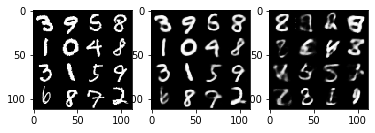

<Epoch:208/1000, Step:185/545>total_loss: 101.0892, kl_loss: 24.4998, recon_loss: 76.5894
<Epoch:209/1000, Step:140/545>total_loss: 103.9145, kl_loss: 24.2391, recon_loss: 79.6754
<Epoch:210/1000, Step:095/545>total_loss: 99.3277, kl_loss: 24.1600, recon_loss: 75.1677
<Epoch:211/1000, Step:050/545>total_loss: 100.7579, kl_loss: 24.1318, recon_loss: 76.6262
<Epoch:212/1000, Step:005/545>total_loss: 97.1351, kl_loss: 23.9330, recon_loss: 73.2021


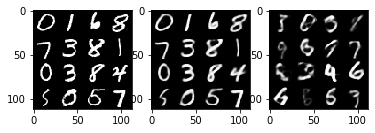

<Epoch:212/1000, Step:505/545>total_loss: 100.3394, kl_loss: 24.3357, recon_loss: 76.0037
<Epoch:213/1000, Step:460/545>total_loss: 100.3606, kl_loss: 24.0560, recon_loss: 76.3047
<Epoch:214/1000, Step:415/545>total_loss: 101.1562, kl_loss: 24.2049, recon_loss: 76.9514
<Epoch:215/1000, Step:370/545>total_loss: 96.4530, kl_loss: 23.1310, recon_loss: 73.3219
<Epoch:216/1000, Step:325/545>total_loss: 100.3667, kl_loss: 24.1951, recon_loss: 76.1716


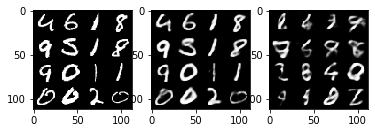

<Epoch:217/1000, Step:280/545>total_loss: 99.1318, kl_loss: 24.1613, recon_loss: 74.9705
<Epoch:218/1000, Step:235/545>total_loss: 102.1517, kl_loss: 24.0726, recon_loss: 78.0792
<Epoch:219/1000, Step:190/545>total_loss: 101.0482, kl_loss: 24.4132, recon_loss: 76.6350
<Epoch:220/1000, Step:145/545>total_loss: 102.4228, kl_loss: 24.7105, recon_loss: 77.7123
<Epoch:221/1000, Step:100/545>total_loss: 101.4874, kl_loss: 24.2380, recon_loss: 77.2494


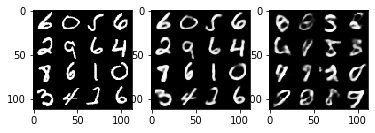

<Epoch:222/1000, Step:055/545>total_loss: 99.9260, kl_loss: 24.3526, recon_loss: 75.5735
<Epoch:223/1000, Step:010/545>total_loss: 101.3212, kl_loss: 24.0861, recon_loss: 77.2350
<Epoch:223/1000, Step:510/545>total_loss: 98.3166, kl_loss: 23.7741, recon_loss: 74.5425
<Epoch:224/1000, Step:465/545>total_loss: 101.1594, kl_loss: 24.1222, recon_loss: 77.0372
<Epoch:225/1000, Step:420/545>total_loss: 101.3877, kl_loss: 24.3179, recon_loss: 77.0697


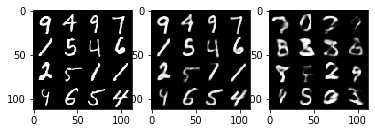

<Epoch:226/1000, Step:375/545>total_loss: 99.7788, kl_loss: 23.9552, recon_loss: 75.8236
<Epoch:227/1000, Step:330/545>total_loss: 101.8921, kl_loss: 24.5936, recon_loss: 77.2985
<Epoch:228/1000, Step:285/545>total_loss: 97.8489, kl_loss: 23.6219, recon_loss: 74.2269
<Epoch:229/1000, Step:240/545>total_loss: 99.5326, kl_loss: 24.1384, recon_loss: 75.3942
<Epoch:230/1000, Step:195/545>total_loss: 101.8214, kl_loss: 24.4770, recon_loss: 77.3443


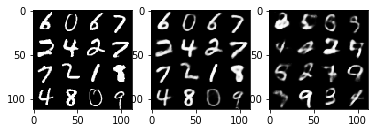

<Epoch:231/1000, Step:150/545>total_loss: 103.2309, kl_loss: 24.6044, recon_loss: 78.6265
<Epoch:232/1000, Step:105/545>total_loss: 102.6799, kl_loss: 24.6226, recon_loss: 78.0572
<Epoch:233/1000, Step:060/545>total_loss: 100.2234, kl_loss: 23.8373, recon_loss: 76.3860
<Epoch:234/1000, Step:015/545>total_loss: 103.4594, kl_loss: 24.6580, recon_loss: 78.8014
<Epoch:234/1000, Step:515/545>total_loss: 97.0710, kl_loss: 24.5017, recon_loss: 72.5694


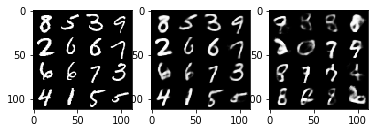

<Epoch:235/1000, Step:470/545>total_loss: 99.9240, kl_loss: 23.9118, recon_loss: 76.0121
<Epoch:236/1000, Step:425/545>total_loss: 99.6408, kl_loss: 24.0531, recon_loss: 75.5877
<Epoch:237/1000, Step:380/545>total_loss: 100.6172, kl_loss: 24.3539, recon_loss: 76.2633
<Epoch:238/1000, Step:335/545>total_loss: 103.1198, kl_loss: 24.2121, recon_loss: 78.9076
<Epoch:239/1000, Step:290/545>total_loss: 96.4416, kl_loss: 23.5808, recon_loss: 72.8608


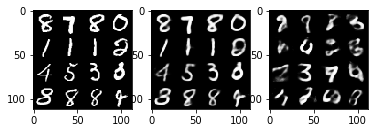

<Epoch:240/1000, Step:245/545>total_loss: 96.5224, kl_loss: 23.7039, recon_loss: 72.8186
<Epoch:241/1000, Step:200/545>total_loss: 98.9887, kl_loss: 24.2853, recon_loss: 74.7035
<Epoch:242/1000, Step:155/545>total_loss: 99.5110, kl_loss: 23.7728, recon_loss: 75.7382
<Epoch:243/1000, Step:110/545>total_loss: 97.3372, kl_loss: 24.1823, recon_loss: 73.1550
<Epoch:244/1000, Step:065/545>total_loss: 95.6984, kl_loss: 23.3285, recon_loss: 72.3699


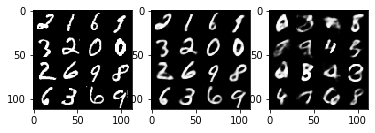

<Epoch:245/1000, Step:020/545>total_loss: 98.8305, kl_loss: 24.2821, recon_loss: 74.5485
<Epoch:245/1000, Step:520/545>total_loss: 100.7878, kl_loss: 24.3764, recon_loss: 76.4114
<Epoch:246/1000, Step:475/545>total_loss: 95.7673, kl_loss: 23.4240, recon_loss: 72.3433
<Epoch:247/1000, Step:430/545>total_loss: 102.3581, kl_loss: 24.3590, recon_loss: 77.9991
<Epoch:248/1000, Step:385/545>total_loss: 104.5011, kl_loss: 24.7648, recon_loss: 79.7363


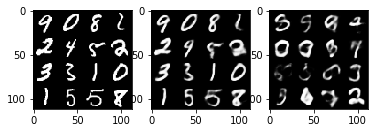

<Epoch:249/1000, Step:340/545>total_loss: 101.2735, kl_loss: 24.4289, recon_loss: 76.8445
<Epoch:250/1000, Step:295/545>total_loss: 97.8136, kl_loss: 23.6037, recon_loss: 74.2099
<Epoch:251/1000, Step:250/545>total_loss: 102.0230, kl_loss: 24.8271, recon_loss: 77.1960
<Epoch:252/1000, Step:205/545>total_loss: 100.4473, kl_loss: 23.9299, recon_loss: 76.5174
<Epoch:253/1000, Step:160/545>total_loss: 101.4193, kl_loss: 24.1321, recon_loss: 77.2872


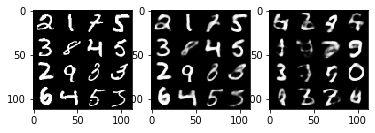

<Epoch:254/1000, Step:115/545>total_loss: 104.0989, kl_loss: 24.2005, recon_loss: 79.8984
<Epoch:255/1000, Step:070/545>total_loss: 98.0133, kl_loss: 23.8916, recon_loss: 74.1216
<Epoch:256/1000, Step:025/545>total_loss: 97.0827, kl_loss: 24.1182, recon_loss: 72.9644
<Epoch:256/1000, Step:525/545>total_loss: 101.4031, kl_loss: 24.2044, recon_loss: 77.1988
<Epoch:257/1000, Step:480/545>total_loss: 98.0756, kl_loss: 24.2292, recon_loss: 73.8463


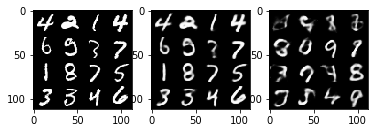

<Epoch:258/1000, Step:435/545>total_loss: 101.5193, kl_loss: 24.3559, recon_loss: 77.1635
<Epoch:259/1000, Step:390/545>total_loss: 99.5666, kl_loss: 24.0515, recon_loss: 75.5150
<Epoch:260/1000, Step:345/545>total_loss: 100.2348, kl_loss: 24.7666, recon_loss: 75.4682
<Epoch:261/1000, Step:300/545>total_loss: 100.9701, kl_loss: 24.1817, recon_loss: 76.7884
<Epoch:262/1000, Step:255/545>total_loss: 95.5329, kl_loss: 23.5197, recon_loss: 72.0133


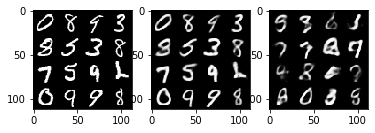

<Epoch:263/1000, Step:210/545>total_loss: 99.5917, kl_loss: 24.4452, recon_loss: 75.1464
<Epoch:264/1000, Step:165/545>total_loss: 99.5870, kl_loss: 23.9580, recon_loss: 75.6290
<Epoch:265/1000, Step:120/545>total_loss: 103.1492, kl_loss: 23.9476, recon_loss: 79.2016
<Epoch:266/1000, Step:075/545>total_loss: 98.0529, kl_loss: 24.2441, recon_loss: 73.8087
<Epoch:267/1000, Step:030/545>total_loss: 102.4501, kl_loss: 24.6691, recon_loss: 77.7810


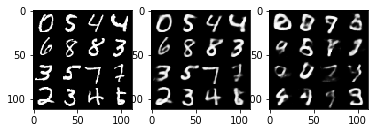

<Epoch:267/1000, Step:530/545>total_loss: 105.0337, kl_loss: 24.7547, recon_loss: 80.2790
<Epoch:268/1000, Step:485/545>total_loss: 97.7024, kl_loss: 24.0292, recon_loss: 73.6732
<Epoch:269/1000, Step:440/545>total_loss: 95.5091, kl_loss: 23.2370, recon_loss: 72.2721
<Epoch:270/1000, Step:395/545>total_loss: 98.6089, kl_loss: 24.2074, recon_loss: 74.4015
<Epoch:271/1000, Step:350/545>total_loss: 99.5714, kl_loss: 24.0623, recon_loss: 75.5090


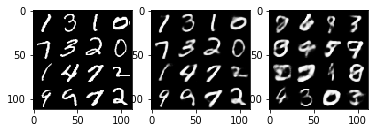

<Epoch:272/1000, Step:305/545>total_loss: 101.0510, kl_loss: 24.0477, recon_loss: 77.0034
<Epoch:273/1000, Step:260/545>total_loss: 98.7558, kl_loss: 24.0251, recon_loss: 74.7307
<Epoch:274/1000, Step:215/545>total_loss: 98.3341, kl_loss: 24.0074, recon_loss: 74.3267
<Epoch:275/1000, Step:170/545>total_loss: 99.9987, kl_loss: 24.2061, recon_loss: 75.7926
<Epoch:276/1000, Step:125/545>total_loss: 98.4612, kl_loss: 24.2946, recon_loss: 74.1666


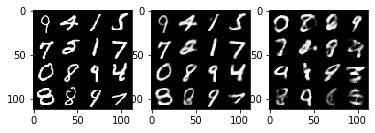

<Epoch:277/1000, Step:080/545>total_loss: 101.3167, kl_loss: 24.2848, recon_loss: 77.0318
<Epoch:278/1000, Step:035/545>total_loss: 98.1789, kl_loss: 23.9709, recon_loss: 74.2080
<Epoch:278/1000, Step:535/545>total_loss: 102.3864, kl_loss: 24.3345, recon_loss: 78.0519
<Epoch:279/1000, Step:490/545>total_loss: 100.1573, kl_loss: 23.8778, recon_loss: 76.2796
<Epoch:280/1000, Step:445/545>total_loss: 97.0338, kl_loss: 23.4737, recon_loss: 73.5601


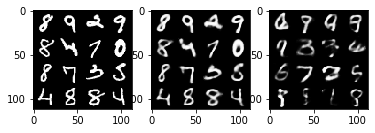

<Epoch:281/1000, Step:400/545>total_loss: 96.4761, kl_loss: 24.0281, recon_loss: 72.4479
<Epoch:282/1000, Step:355/545>total_loss: 103.1414, kl_loss: 24.6275, recon_loss: 78.5139
<Epoch:283/1000, Step:310/545>total_loss: 99.5382, kl_loss: 24.0057, recon_loss: 75.5325
<Epoch:284/1000, Step:265/545>total_loss: 97.9389, kl_loss: 24.0409, recon_loss: 73.8979
<Epoch:285/1000, Step:220/545>total_loss: 99.1527, kl_loss: 24.1886, recon_loss: 74.9641


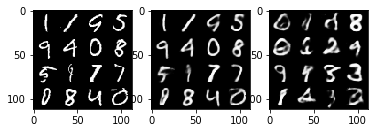

<Epoch:286/1000, Step:175/545>total_loss: 97.3721, kl_loss: 23.9917, recon_loss: 73.3804
<Epoch:287/1000, Step:130/545>total_loss: 98.6455, kl_loss: 23.8411, recon_loss: 74.8044
<Epoch:288/1000, Step:085/545>total_loss: 94.9999, kl_loss: 23.7491, recon_loss: 71.2508
<Epoch:289/1000, Step:040/545>total_loss: 101.3487, kl_loss: 24.5607, recon_loss: 76.7881
<Epoch:289/1000, Step:540/545>total_loss: 100.8666, kl_loss: 24.2387, recon_loss: 76.6279


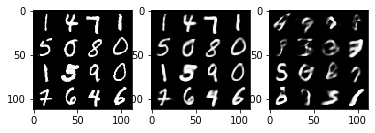

<Epoch:290/1000, Step:495/545>total_loss: 100.0653, kl_loss: 24.2057, recon_loss: 75.8596
<Epoch:291/1000, Step:450/545>total_loss: 99.5884, kl_loss: 24.1268, recon_loss: 75.4617
<Epoch:292/1000, Step:405/545>total_loss: 97.7555, kl_loss: 23.8844, recon_loss: 73.8711
<Epoch:293/1000, Step:360/545>total_loss: 99.2438, kl_loss: 24.0120, recon_loss: 75.2318
<Epoch:294/1000, Step:315/545>total_loss: 101.5827, kl_loss: 25.1932, recon_loss: 76.3894


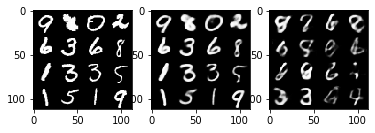

<Epoch:295/1000, Step:270/545>total_loss: 100.9888, kl_loss: 24.1219, recon_loss: 76.8668
<Epoch:296/1000, Step:225/545>total_loss: 98.8114, kl_loss: 23.8545, recon_loss: 74.9569
<Epoch:297/1000, Step:180/545>total_loss: 101.3270, kl_loss: 24.3865, recon_loss: 76.9405
<Epoch:298/1000, Step:135/545>total_loss: 97.7455, kl_loss: 23.6946, recon_loss: 74.0509
<Epoch:299/1000, Step:090/545>total_loss: 99.3033, kl_loss: 24.0139, recon_loss: 75.2894


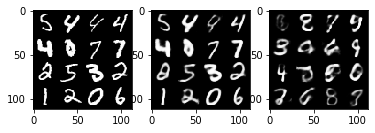

<Epoch:300/1000, Step:045/545>total_loss: 104.1202, kl_loss: 24.8143, recon_loss: 79.3059
<Epoch:300/1000, Step:545/545>total_loss: 98.3719, kl_loss: 24.2912, recon_loss: 74.0807
<Epoch:301/1000, Step:500/545>total_loss: 100.0781, kl_loss: 23.9959, recon_loss: 76.0822
<Epoch:302/1000, Step:455/545>total_loss: 103.3377, kl_loss: 24.6466, recon_loss: 78.6912
<Epoch:303/1000, Step:410/545>total_loss: 97.6561, kl_loss: 23.6070, recon_loss: 74.0490


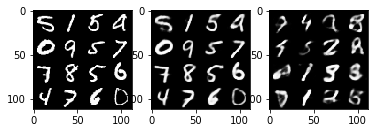

<Epoch:304/1000, Step:365/545>total_loss: 104.0916, kl_loss: 24.6859, recon_loss: 79.4057
<Epoch:305/1000, Step:320/545>total_loss: 100.8676, kl_loss: 24.4113, recon_loss: 76.4563
<Epoch:306/1000, Step:275/545>total_loss: 97.7635, kl_loss: 24.0756, recon_loss: 73.6879
<Epoch:307/1000, Step:230/545>total_loss: 103.0100, kl_loss: 24.8402, recon_loss: 78.1699
<Epoch:308/1000, Step:185/545>total_loss: 99.4850, kl_loss: 23.8321, recon_loss: 75.6530


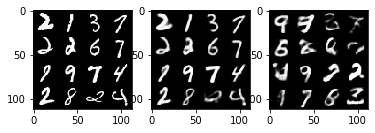

<Epoch:309/1000, Step:140/545>total_loss: 99.8712, kl_loss: 23.8577, recon_loss: 76.0135
<Epoch:310/1000, Step:095/545>total_loss: 97.5857, kl_loss: 24.0255, recon_loss: 73.5601
<Epoch:311/1000, Step:050/545>total_loss: 97.0690, kl_loss: 23.8272, recon_loss: 73.2418
<Epoch:312/1000, Step:005/545>total_loss: 99.0059, kl_loss: 23.8997, recon_loss: 75.1062
<Epoch:312/1000, Step:505/545>total_loss: 102.2046, kl_loss: 24.5582, recon_loss: 77.6463


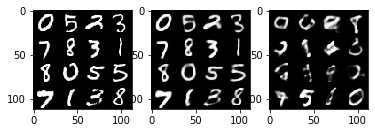

<Epoch:313/1000, Step:460/545>total_loss: 95.9654, kl_loss: 23.7502, recon_loss: 72.2153
<Epoch:314/1000, Step:415/545>total_loss: 97.9780, kl_loss: 23.8395, recon_loss: 74.1385
<Epoch:315/1000, Step:370/545>total_loss: 102.6156, kl_loss: 24.4614, recon_loss: 78.1542
<Epoch:316/1000, Step:325/545>total_loss: 103.0559, kl_loss: 24.5470, recon_loss: 78.5089
<Epoch:317/1000, Step:280/545>total_loss: 101.3692, kl_loss: 24.6038, recon_loss: 76.7654


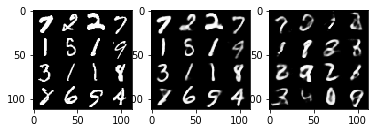

<Epoch:318/1000, Step:235/545>total_loss: 100.8710, kl_loss: 24.2335, recon_loss: 76.6375
<Epoch:319/1000, Step:190/545>total_loss: 99.1015, kl_loss: 23.7587, recon_loss: 75.3428
<Epoch:320/1000, Step:145/545>total_loss: 100.0091, kl_loss: 24.0738, recon_loss: 75.9353
<Epoch:321/1000, Step:100/545>total_loss: 96.2131, kl_loss: 23.8978, recon_loss: 72.3153
<Epoch:322/1000, Step:055/545>total_loss: 99.6660, kl_loss: 24.1884, recon_loss: 75.4776


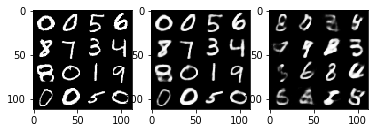

<Epoch:323/1000, Step:010/545>total_loss: 102.8007, kl_loss: 24.4486, recon_loss: 78.3521
<Epoch:323/1000, Step:510/545>total_loss: 101.0527, kl_loss: 24.5159, recon_loss: 76.5368
<Epoch:324/1000, Step:465/545>total_loss: 98.9883, kl_loss: 24.3022, recon_loss: 74.6860
<Epoch:325/1000, Step:420/545>total_loss: 98.9095, kl_loss: 24.0891, recon_loss: 74.8204
<Epoch:326/1000, Step:375/545>total_loss: 97.9209, kl_loss: 23.9134, recon_loss: 74.0075


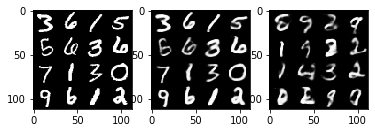

<Epoch:327/1000, Step:330/545>total_loss: 97.3038, kl_loss: 24.2022, recon_loss: 73.1017
<Epoch:328/1000, Step:285/545>total_loss: 100.8983, kl_loss: 24.1600, recon_loss: 76.7383
<Epoch:329/1000, Step:240/545>total_loss: 97.2509, kl_loss: 24.0343, recon_loss: 73.2165
<Epoch:330/1000, Step:195/545>total_loss: 99.5523, kl_loss: 23.8925, recon_loss: 75.6598
<Epoch:331/1000, Step:150/545>total_loss: 98.1499, kl_loss: 23.6801, recon_loss: 74.4698


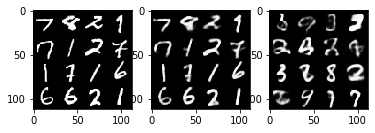

<Epoch:332/1000, Step:105/545>total_loss: 98.9792, kl_loss: 24.7547, recon_loss: 74.2246
<Epoch:333/1000, Step:060/545>total_loss: 100.6992, kl_loss: 24.5433, recon_loss: 76.1559
<Epoch:334/1000, Step:015/545>total_loss: 100.0954, kl_loss: 24.5084, recon_loss: 75.5870
<Epoch:334/1000, Step:515/545>total_loss: 100.4528, kl_loss: 24.4865, recon_loss: 75.9663
<Epoch:335/1000, Step:470/545>total_loss: 94.2720, kl_loss: 23.4638, recon_loss: 70.8081


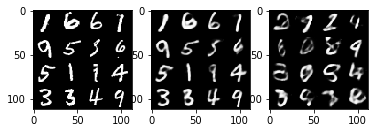

<Epoch:336/1000, Step:425/545>total_loss: 103.3243, kl_loss: 24.5034, recon_loss: 78.8208
<Epoch:337/1000, Step:380/545>total_loss: 96.3495, kl_loss: 23.4411, recon_loss: 72.9084
<Epoch:338/1000, Step:335/545>total_loss: 98.2177, kl_loss: 23.8237, recon_loss: 74.3940
<Epoch:339/1000, Step:290/545>total_loss: 98.4049, kl_loss: 23.9524, recon_loss: 74.4525
<Epoch:340/1000, Step:245/545>total_loss: 99.6986, kl_loss: 24.3585, recon_loss: 75.3401


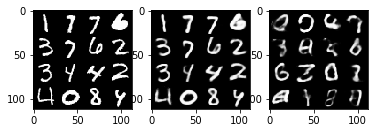

<Epoch:341/1000, Step:200/545>total_loss: 103.5232, kl_loss: 24.4048, recon_loss: 79.1184
<Epoch:342/1000, Step:155/545>total_loss: 102.7340, kl_loss: 24.9920, recon_loss: 77.7420
<Epoch:343/1000, Step:110/545>total_loss: 97.6563, kl_loss: 23.9297, recon_loss: 73.7265
<Epoch:344/1000, Step:065/545>total_loss: 100.2440, kl_loss: 24.3066, recon_loss: 75.9374
<Epoch:345/1000, Step:020/545>total_loss: 98.6289, kl_loss: 24.4040, recon_loss: 74.2250


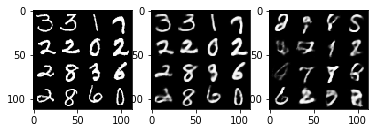

<Epoch:345/1000, Step:520/545>total_loss: 103.2373, kl_loss: 24.4945, recon_loss: 78.7428
<Epoch:346/1000, Step:475/545>total_loss: 97.8304, kl_loss: 24.3688, recon_loss: 73.4617
<Epoch:347/1000, Step:430/545>total_loss: 100.5404, kl_loss: 23.9835, recon_loss: 76.5569
<Epoch:348/1000, Step:385/545>total_loss: 101.5241, kl_loss: 24.4113, recon_loss: 77.1128
<Epoch:349/1000, Step:340/545>total_loss: 99.7641, kl_loss: 24.7789, recon_loss: 74.9852


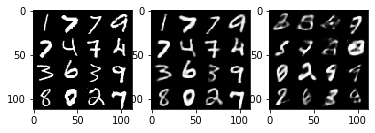

<Epoch:350/1000, Step:295/545>total_loss: 99.0957, kl_loss: 24.4439, recon_loss: 74.6519
<Epoch:351/1000, Step:250/545>total_loss: 98.0351, kl_loss: 24.0063, recon_loss: 74.0288
<Epoch:352/1000, Step:205/545>total_loss: 99.8116, kl_loss: 24.2954, recon_loss: 75.5162
<Epoch:353/1000, Step:160/545>total_loss: 100.6306, kl_loss: 24.6379, recon_loss: 75.9927
<Epoch:354/1000, Step:115/545>total_loss: 100.1572, kl_loss: 24.4186, recon_loss: 75.7386


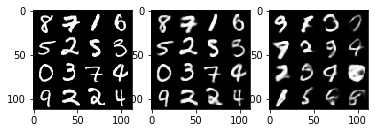

<Epoch:355/1000, Step:070/545>total_loss: 100.4817, kl_loss: 24.3034, recon_loss: 76.1783
<Epoch:356/1000, Step:025/545>total_loss: 98.4051, kl_loss: 23.6898, recon_loss: 74.7152
<Epoch:356/1000, Step:525/545>total_loss: 101.1523, kl_loss: 24.5408, recon_loss: 76.6115
<Epoch:357/1000, Step:480/545>total_loss: 98.1872, kl_loss: 24.3393, recon_loss: 73.8479
<Epoch:358/1000, Step:435/545>total_loss: 99.6751, kl_loss: 24.6187, recon_loss: 75.0564


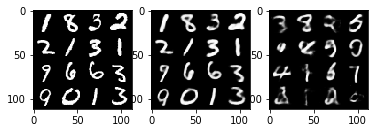

<Epoch:359/1000, Step:390/545>total_loss: 99.7780, kl_loss: 24.1781, recon_loss: 75.5999
<Epoch:360/1000, Step:345/545>total_loss: 102.4158, kl_loss: 24.6880, recon_loss: 77.7278
<Epoch:361/1000, Step:300/545>total_loss: 101.5990, kl_loss: 24.4885, recon_loss: 77.1106
<Epoch:362/1000, Step:255/545>total_loss: 102.2745, kl_loss: 24.4127, recon_loss: 77.8618
<Epoch:363/1000, Step:210/545>total_loss: 99.9630, kl_loss: 24.5839, recon_loss: 75.3792


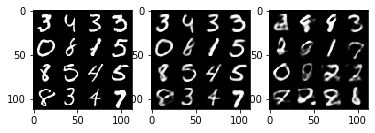

<Epoch:364/1000, Step:165/545>total_loss: 100.8960, kl_loss: 24.6435, recon_loss: 76.2525
<Epoch:365/1000, Step:120/545>total_loss: 98.1238, kl_loss: 24.0080, recon_loss: 74.1158
<Epoch:366/1000, Step:075/545>total_loss: 98.6608, kl_loss: 24.3072, recon_loss: 74.3536
<Epoch:367/1000, Step:030/545>total_loss: 95.8082, kl_loss: 23.7958, recon_loss: 72.0124
<Epoch:367/1000, Step:530/545>total_loss: 98.6900, kl_loss: 23.7583, recon_loss: 74.9317


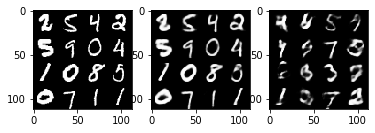

<Epoch:368/1000, Step:485/545>total_loss: 97.2032, kl_loss: 24.5716, recon_loss: 72.6316
<Epoch:369/1000, Step:440/545>total_loss: 97.2060, kl_loss: 24.0010, recon_loss: 73.2051
<Epoch:370/1000, Step:395/545>total_loss: 98.0179, kl_loss: 23.7801, recon_loss: 74.2378
<Epoch:371/1000, Step:350/545>total_loss: 104.4441, kl_loss: 24.8994, recon_loss: 79.5447
<Epoch:372/1000, Step:305/545>total_loss: 99.2502, kl_loss: 24.0464, recon_loss: 75.2039


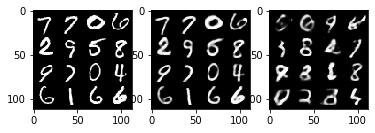

<Epoch:373/1000, Step:260/545>total_loss: 102.6529, kl_loss: 24.4666, recon_loss: 78.1863
<Epoch:374/1000, Step:215/545>total_loss: 97.9817, kl_loss: 24.1253, recon_loss: 73.8564
<Epoch:375/1000, Step:170/545>total_loss: 101.2038, kl_loss: 24.7037, recon_loss: 76.5002
<Epoch:376/1000, Step:125/545>total_loss: 101.2486, kl_loss: 24.4678, recon_loss: 76.7808
<Epoch:377/1000, Step:080/545>total_loss: 96.4469, kl_loss: 23.8584, recon_loss: 72.5885


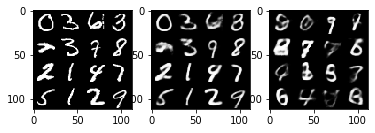

<Epoch:378/1000, Step:035/545>total_loss: 96.4771, kl_loss: 24.2880, recon_loss: 72.1890
<Epoch:378/1000, Step:535/545>total_loss: 97.3994, kl_loss: 24.3605, recon_loss: 73.0389
<Epoch:379/1000, Step:490/545>total_loss: 100.0589, kl_loss: 24.1707, recon_loss: 75.8882
<Epoch:380/1000, Step:445/545>total_loss: 100.2709, kl_loss: 24.3467, recon_loss: 75.9243
<Epoch:381/1000, Step:400/545>total_loss: 98.9620, kl_loss: 24.2010, recon_loss: 74.7609


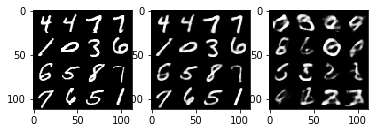

<Epoch:382/1000, Step:355/545>total_loss: 103.6925, kl_loss: 24.6026, recon_loss: 79.0898
<Epoch:383/1000, Step:310/545>total_loss: 96.7628, kl_loss: 24.0237, recon_loss: 72.7391
<Epoch:384/1000, Step:265/545>total_loss: 99.4888, kl_loss: 24.4315, recon_loss: 75.0573
<Epoch:385/1000, Step:220/545>total_loss: 97.9928, kl_loss: 24.6222, recon_loss: 73.3705
<Epoch:386/1000, Step:175/545>total_loss: 98.6605, kl_loss: 23.7159, recon_loss: 74.9446


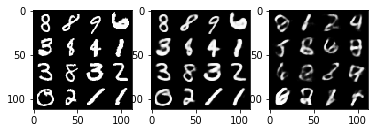

<Epoch:387/1000, Step:130/545>total_loss: 101.2224, kl_loss: 24.8279, recon_loss: 76.3946
<Epoch:388/1000, Step:085/545>total_loss: 96.0498, kl_loss: 23.7795, recon_loss: 72.2703
<Epoch:389/1000, Step:040/545>total_loss: 102.2604, kl_loss: 24.3023, recon_loss: 77.9581
<Epoch:389/1000, Step:540/545>total_loss: 98.2010, kl_loss: 24.4784, recon_loss: 73.7226
<Epoch:390/1000, Step:495/545>total_loss: 100.4283, kl_loss: 24.5263, recon_loss: 75.9020


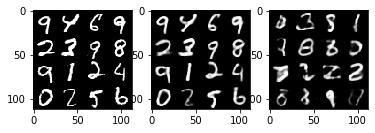

<Epoch:391/1000, Step:450/545>total_loss: 100.0704, kl_loss: 24.2297, recon_loss: 75.8407
<Epoch:392/1000, Step:405/545>total_loss: 100.8925, kl_loss: 24.5081, recon_loss: 76.3844
<Epoch:393/1000, Step:360/545>total_loss: 98.0431, kl_loss: 23.8266, recon_loss: 74.2165
<Epoch:394/1000, Step:315/545>total_loss: 100.0483, kl_loss: 24.3879, recon_loss: 75.6604
<Epoch:395/1000, Step:270/545>total_loss: 98.6980, kl_loss: 24.0946, recon_loss: 74.6034


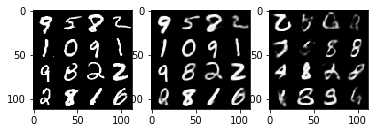

<Epoch:396/1000, Step:225/545>total_loss: 100.8847, kl_loss: 24.0714, recon_loss: 76.8133
<Epoch:397/1000, Step:180/545>total_loss: 99.7655, kl_loss: 23.9240, recon_loss: 75.8415
<Epoch:398/1000, Step:135/545>total_loss: 98.9427, kl_loss: 24.1902, recon_loss: 74.7525
<Epoch:399/1000, Step:090/545>total_loss: 99.8559, kl_loss: 24.2084, recon_loss: 75.6475
<Epoch:400/1000, Step:045/545>total_loss: 98.3190, kl_loss: 23.8763, recon_loss: 74.4427


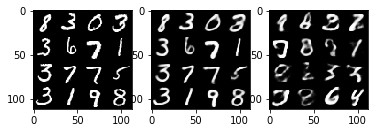

<Epoch:400/1000, Step:545/545>total_loss: 97.5430, kl_loss: 23.9880, recon_loss: 73.5550
<Epoch:401/1000, Step:500/545>total_loss: 95.9870, kl_loss: 23.6622, recon_loss: 72.3249
<Epoch:402/1000, Step:455/545>total_loss: 98.5233, kl_loss: 24.3092, recon_loss: 74.2141
<Epoch:403/1000, Step:410/545>total_loss: 99.4129, kl_loss: 24.2228, recon_loss: 75.1901
<Epoch:404/1000, Step:365/545>total_loss: 104.0838, kl_loss: 25.1095, recon_loss: 78.9743


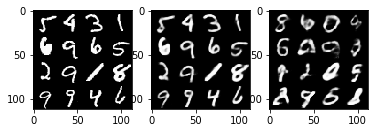

<Epoch:405/1000, Step:320/545>total_loss: 100.6840, kl_loss: 24.0834, recon_loss: 76.6006
<Epoch:406/1000, Step:275/545>total_loss: 99.3985, kl_loss: 24.6341, recon_loss: 74.7644
<Epoch:407/1000, Step:230/545>total_loss: 99.3513, kl_loss: 24.0731, recon_loss: 75.2782
<Epoch:408/1000, Step:185/545>total_loss: 100.5653, kl_loss: 24.9526, recon_loss: 75.6127
<Epoch:409/1000, Step:140/545>total_loss: 97.4050, kl_loss: 24.0048, recon_loss: 73.4002


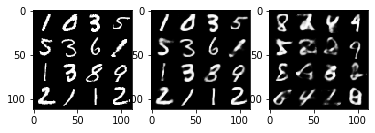

<Epoch:410/1000, Step:095/545>total_loss: 98.3951, kl_loss: 23.9200, recon_loss: 74.4752
<Epoch:411/1000, Step:050/545>total_loss: 97.7613, kl_loss: 24.1443, recon_loss: 73.6170
<Epoch:412/1000, Step:005/545>total_loss: 96.3487, kl_loss: 23.8129, recon_loss: 72.5358
<Epoch:412/1000, Step:505/545>total_loss: 98.3699, kl_loss: 23.9466, recon_loss: 74.4233
<Epoch:413/1000, Step:460/545>total_loss: 98.7870, kl_loss: 24.1651, recon_loss: 74.6219


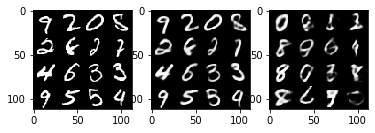

<Epoch:414/1000, Step:415/545>total_loss: 101.9961, kl_loss: 24.5024, recon_loss: 77.4937
<Epoch:415/1000, Step:370/545>total_loss: 101.3970, kl_loss: 24.4501, recon_loss: 76.9469
<Epoch:416/1000, Step:325/545>total_loss: 101.3127, kl_loss: 24.5808, recon_loss: 76.7319
<Epoch:417/1000, Step:280/545>total_loss: 100.6439, kl_loss: 24.4804, recon_loss: 76.1635
<Epoch:418/1000, Step:235/545>total_loss: 97.0440, kl_loss: 23.5106, recon_loss: 73.5334


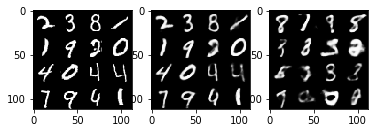

<Epoch:419/1000, Step:190/545>total_loss: 102.0381, kl_loss: 24.8129, recon_loss: 77.2252
<Epoch:420/1000, Step:145/545>total_loss: 91.8640, kl_loss: 23.0252, recon_loss: 68.8388
<Epoch:421/1000, Step:100/545>total_loss: 97.1187, kl_loss: 24.0042, recon_loss: 73.1145
<Epoch:422/1000, Step:055/545>total_loss: 97.7004, kl_loss: 23.7135, recon_loss: 73.9869
<Epoch:423/1000, Step:010/545>total_loss: 99.6557, kl_loss: 24.5231, recon_loss: 75.1326


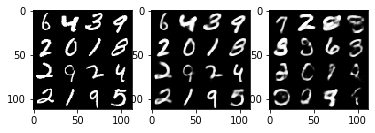

<Epoch:423/1000, Step:510/545>total_loss: 98.0293, kl_loss: 24.4111, recon_loss: 73.6182
<Epoch:424/1000, Step:465/545>total_loss: 101.1467, kl_loss: 24.5861, recon_loss: 76.5606
<Epoch:425/1000, Step:420/545>total_loss: 99.5394, kl_loss: 24.3052, recon_loss: 75.2343
<Epoch:426/1000, Step:375/545>total_loss: 98.2955, kl_loss: 24.1743, recon_loss: 74.1212
<Epoch:427/1000, Step:330/545>total_loss: 101.8744, kl_loss: 24.7371, recon_loss: 77.1374


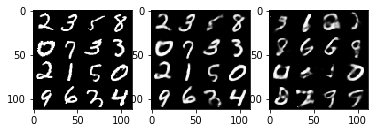

<Epoch:428/1000, Step:285/545>total_loss: 96.3330, kl_loss: 23.9564, recon_loss: 72.3766
<Epoch:429/1000, Step:240/545>total_loss: 98.9946, kl_loss: 24.2567, recon_loss: 74.7379
<Epoch:430/1000, Step:195/545>total_loss: 102.8015, kl_loss: 24.5975, recon_loss: 78.2040
<Epoch:431/1000, Step:150/545>total_loss: 100.9752, kl_loss: 24.4119, recon_loss: 76.5632
<Epoch:432/1000, Step:105/545>total_loss: 97.8176, kl_loss: 24.2830, recon_loss: 73.5346


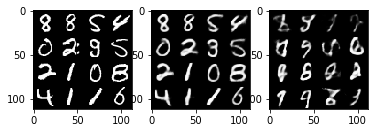

<Epoch:433/1000, Step:060/545>total_loss: 97.2470, kl_loss: 24.2324, recon_loss: 73.0146
<Epoch:434/1000, Step:015/545>total_loss: 96.0578, kl_loss: 23.8510, recon_loss: 72.2068
<Epoch:434/1000, Step:515/545>total_loss: 97.9610, kl_loss: 24.0446, recon_loss: 73.9164
<Epoch:435/1000, Step:470/545>total_loss: 99.0296, kl_loss: 24.5267, recon_loss: 74.5029
<Epoch:436/1000, Step:425/545>total_loss: 100.3883, kl_loss: 24.4522, recon_loss: 75.9361


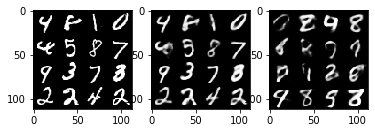

<Epoch:437/1000, Step:380/545>total_loss: 99.7018, kl_loss: 24.4579, recon_loss: 75.2439
<Epoch:438/1000, Step:335/545>total_loss: 96.0295, kl_loss: 23.8124, recon_loss: 72.2170
<Epoch:439/1000, Step:290/545>total_loss: 97.9816, kl_loss: 24.2279, recon_loss: 73.7538
<Epoch:440/1000, Step:245/545>total_loss: 100.4593, kl_loss: 24.4221, recon_loss: 76.0372
<Epoch:441/1000, Step:200/545>total_loss: 97.4088, kl_loss: 23.9472, recon_loss: 73.4615


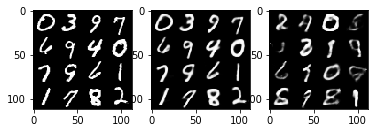

<Epoch:442/1000, Step:155/545>total_loss: 101.7297, kl_loss: 24.8633, recon_loss: 76.8663
<Epoch:443/1000, Step:110/545>total_loss: 94.0154, kl_loss: 23.6770, recon_loss: 70.3384
<Epoch:444/1000, Step:065/545>total_loss: 102.1634, kl_loss: 24.4008, recon_loss: 77.7626
<Epoch:445/1000, Step:020/545>total_loss: 97.5822, kl_loss: 24.3081, recon_loss: 73.2741
<Epoch:445/1000, Step:520/545>total_loss: 98.8368, kl_loss: 24.5407, recon_loss: 74.2961


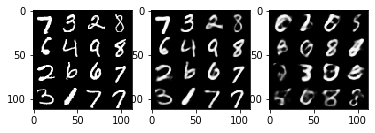

<Epoch:446/1000, Step:475/545>total_loss: 98.9790, kl_loss: 24.0229, recon_loss: 74.9561
<Epoch:447/1000, Step:430/545>total_loss: 99.0862, kl_loss: 24.5874, recon_loss: 74.4987
<Epoch:448/1000, Step:385/545>total_loss: 99.7986, kl_loss: 24.3247, recon_loss: 75.4738
<Epoch:449/1000, Step:340/545>total_loss: 97.2452, kl_loss: 23.8199, recon_loss: 73.4253
<Epoch:450/1000, Step:295/545>total_loss: 97.5502, kl_loss: 24.1067, recon_loss: 73.4435


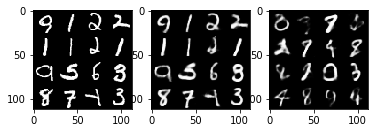

<Epoch:451/1000, Step:250/545>total_loss: 98.6005, kl_loss: 24.0403, recon_loss: 74.5602
<Epoch:452/1000, Step:205/545>total_loss: 97.7391, kl_loss: 23.8538, recon_loss: 73.8852
<Epoch:453/1000, Step:160/545>total_loss: 98.2573, kl_loss: 24.2340, recon_loss: 74.0233
<Epoch:454/1000, Step:115/545>total_loss: 99.5311, kl_loss: 24.1188, recon_loss: 75.4123
<Epoch:455/1000, Step:070/545>total_loss: 99.5747, kl_loss: 24.1993, recon_loss: 75.3754


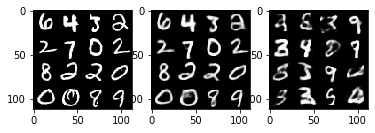

<Epoch:456/1000, Step:025/545>total_loss: 97.8410, kl_loss: 24.1322, recon_loss: 73.7088
<Epoch:456/1000, Step:525/545>total_loss: 96.0983, kl_loss: 23.6167, recon_loss: 72.4815
<Epoch:457/1000, Step:480/545>total_loss: 100.7393, kl_loss: 24.3680, recon_loss: 76.3713
<Epoch:458/1000, Step:435/545>total_loss: 102.3369, kl_loss: 24.7950, recon_loss: 77.5419
<Epoch:459/1000, Step:390/545>total_loss: 99.3847, kl_loss: 24.2431, recon_loss: 75.1415


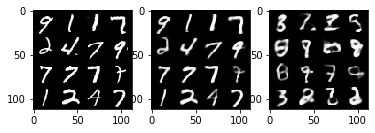

<Epoch:460/1000, Step:345/545>total_loss: 96.6023, kl_loss: 23.9064, recon_loss: 72.6959
<Epoch:461/1000, Step:300/545>total_loss: 98.3043, kl_loss: 23.8445, recon_loss: 74.4598
<Epoch:462/1000, Step:255/545>total_loss: 99.0683, kl_loss: 24.4731, recon_loss: 74.5952
<Epoch:463/1000, Step:210/545>total_loss: 99.2946, kl_loss: 24.7297, recon_loss: 74.5648
<Epoch:464/1000, Step:165/545>total_loss: 94.6154, kl_loss: 23.8282, recon_loss: 70.7873


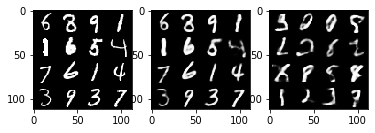

<Epoch:465/1000, Step:120/545>total_loss: 98.3577, kl_loss: 24.2010, recon_loss: 74.1566
<Epoch:466/1000, Step:075/545>total_loss: 100.7242, kl_loss: 24.7156, recon_loss: 76.0086
<Epoch:467/1000, Step:030/545>total_loss: 101.7084, kl_loss: 25.0413, recon_loss: 76.6671
<Epoch:467/1000, Step:530/545>total_loss: 96.9254, kl_loss: 23.6980, recon_loss: 73.2274
<Epoch:468/1000, Step:485/545>total_loss: 95.9826, kl_loss: 23.5654, recon_loss: 72.4172


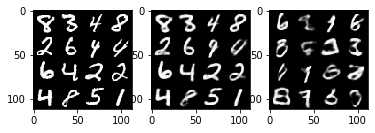

<Epoch:469/1000, Step:440/545>total_loss: 98.7322, kl_loss: 23.9152, recon_loss: 74.8170
<Epoch:470/1000, Step:395/545>total_loss: 96.4582, kl_loss: 24.1376, recon_loss: 72.3207
<Epoch:471/1000, Step:350/545>total_loss: 99.4231, kl_loss: 24.0696, recon_loss: 75.3536
<Epoch:472/1000, Step:305/545>total_loss: 102.7856, kl_loss: 24.8960, recon_loss: 77.8895
<Epoch:473/1000, Step:260/545>total_loss: 98.2160, kl_loss: 23.7440, recon_loss: 74.4720


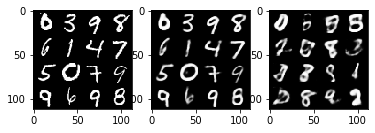

<Epoch:474/1000, Step:215/545>total_loss: 98.4412, kl_loss: 24.2385, recon_loss: 74.2028
<Epoch:475/1000, Step:170/545>total_loss: 98.6035, kl_loss: 24.5275, recon_loss: 74.0760
<Epoch:476/1000, Step:125/545>total_loss: 92.5531, kl_loss: 23.4623, recon_loss: 69.0908
<Epoch:477/1000, Step:080/545>total_loss: 98.6164, kl_loss: 24.1099, recon_loss: 74.5066
<Epoch:478/1000, Step:035/545>total_loss: 96.9073, kl_loss: 24.2164, recon_loss: 72.6909


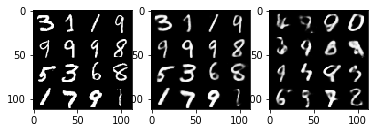

<Epoch:478/1000, Step:535/545>total_loss: 100.0641, kl_loss: 24.1748, recon_loss: 75.8893
<Epoch:479/1000, Step:490/545>total_loss: 97.9633, kl_loss: 24.1394, recon_loss: 73.8239
<Epoch:480/1000, Step:445/545>total_loss: 95.3261, kl_loss: 23.6302, recon_loss: 71.6959
<Epoch:481/1000, Step:400/545>total_loss: 98.7156, kl_loss: 24.3265, recon_loss: 74.3891
<Epoch:482/1000, Step:355/545>total_loss: 103.5407, kl_loss: 25.3139, recon_loss: 78.2268


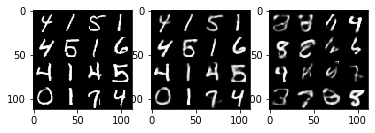

<Epoch:483/1000, Step:310/545>total_loss: 95.9286, kl_loss: 24.2270, recon_loss: 71.7017
<Epoch:484/1000, Step:265/545>total_loss: 95.5402, kl_loss: 23.8730, recon_loss: 71.6672
<Epoch:485/1000, Step:220/545>total_loss: 97.4537, kl_loss: 24.4251, recon_loss: 73.0286
<Epoch:486/1000, Step:175/545>total_loss: 98.6212, kl_loss: 24.4878, recon_loss: 74.1334
<Epoch:487/1000, Step:130/545>total_loss: 100.2758, kl_loss: 24.2174, recon_loss: 76.0584


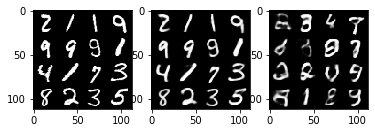

<Epoch:488/1000, Step:085/545>total_loss: 98.6852, kl_loss: 24.3031, recon_loss: 74.3822
<Epoch:489/1000, Step:040/545>total_loss: 99.0416, kl_loss: 24.1244, recon_loss: 74.9172
<Epoch:489/1000, Step:540/545>total_loss: 99.5495, kl_loss: 24.1097, recon_loss: 75.4398
<Epoch:490/1000, Step:495/545>total_loss: 98.9590, kl_loss: 24.4077, recon_loss: 74.5513
<Epoch:491/1000, Step:450/545>total_loss: 96.4066, kl_loss: 23.9420, recon_loss: 72.4646


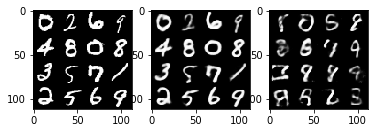

<Epoch:492/1000, Step:405/545>total_loss: 98.7491, kl_loss: 24.0605, recon_loss: 74.6886
<Epoch:493/1000, Step:360/545>total_loss: 97.6025, kl_loss: 24.3169, recon_loss: 73.2856
<Epoch:494/1000, Step:315/545>total_loss: 98.6068, kl_loss: 24.3749, recon_loss: 74.2319
<Epoch:495/1000, Step:270/545>total_loss: 96.1580, kl_loss: 23.9215, recon_loss: 72.2364
<Epoch:496/1000, Step:225/545>total_loss: 99.5616, kl_loss: 24.0844, recon_loss: 75.4772


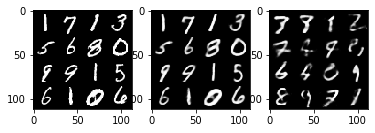

<Epoch:497/1000, Step:180/545>total_loss: 96.6944, kl_loss: 24.3337, recon_loss: 72.3607
<Epoch:498/1000, Step:135/545>total_loss: 102.1759, kl_loss: 24.8381, recon_loss: 77.3377
<Epoch:499/1000, Step:090/545>total_loss: 97.9419, kl_loss: 24.1093, recon_loss: 73.8326
<Epoch:500/1000, Step:045/545>total_loss: 96.7108, kl_loss: 23.9601, recon_loss: 72.7507
<Epoch:500/1000, Step:545/545>total_loss: 97.3473, kl_loss: 24.0531, recon_loss: 73.2942


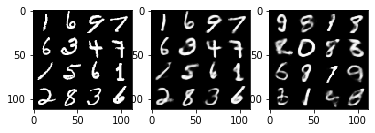

<Epoch:501/1000, Step:500/545>total_loss: 100.9170, kl_loss: 24.3524, recon_loss: 76.5646
<Epoch:502/1000, Step:455/545>total_loss: 100.5509, kl_loss: 24.1825, recon_loss: 76.3684
<Epoch:503/1000, Step:410/545>total_loss: 98.1885, kl_loss: 24.1321, recon_loss: 74.0564
<Epoch:504/1000, Step:365/545>total_loss: 96.8181, kl_loss: 24.3371, recon_loss: 72.4810
<Epoch:505/1000, Step:320/545>total_loss: 98.6571, kl_loss: 24.4048, recon_loss: 74.2524


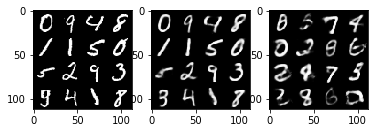

<Epoch:506/1000, Step:275/545>total_loss: 95.2731, kl_loss: 24.0277, recon_loss: 71.2454
<Epoch:507/1000, Step:230/545>total_loss: 98.3189, kl_loss: 23.8333, recon_loss: 74.4856
<Epoch:508/1000, Step:185/545>total_loss: 99.6149, kl_loss: 24.1515, recon_loss: 75.4633
<Epoch:509/1000, Step:140/545>total_loss: 96.4467, kl_loss: 24.1437, recon_loss: 72.3030
<Epoch:510/1000, Step:095/545>total_loss: 98.7412, kl_loss: 24.1767, recon_loss: 74.5645


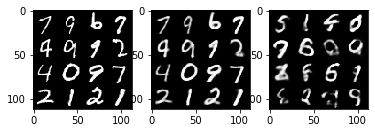

<Epoch:511/1000, Step:050/545>total_loss: 99.8680, kl_loss: 24.6493, recon_loss: 75.2187
<Epoch:512/1000, Step:005/545>total_loss: 95.8082, kl_loss: 23.7656, recon_loss: 72.0426
<Epoch:512/1000, Step:505/545>total_loss: 98.5815, kl_loss: 24.0563, recon_loss: 74.5252
<Epoch:513/1000, Step:460/545>total_loss: 93.7385, kl_loss: 23.2772, recon_loss: 70.4613
<Epoch:514/1000, Step:415/545>total_loss: 97.8353, kl_loss: 24.4480, recon_loss: 73.3873


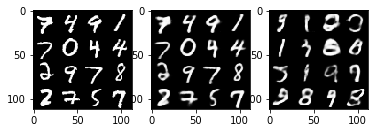

<Epoch:515/1000, Step:370/545>total_loss: 97.3783, kl_loss: 24.0222, recon_loss: 73.3562
<Epoch:516/1000, Step:325/545>total_loss: 97.5352, kl_loss: 24.0825, recon_loss: 73.4528
<Epoch:517/1000, Step:280/545>total_loss: 97.5998, kl_loss: 23.7003, recon_loss: 73.8995
<Epoch:518/1000, Step:235/545>total_loss: 95.3619, kl_loss: 23.7566, recon_loss: 71.6053
<Epoch:519/1000, Step:190/545>total_loss: 99.8681, kl_loss: 24.7558, recon_loss: 75.1123


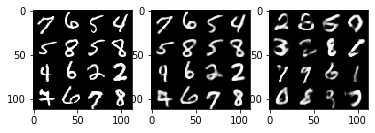

<Epoch:520/1000, Step:145/545>total_loss: 97.8755, kl_loss: 24.2264, recon_loss: 73.6491
<Epoch:521/1000, Step:100/545>total_loss: 95.9536, kl_loss: 23.7887, recon_loss: 72.1649
<Epoch:522/1000, Step:055/545>total_loss: 99.4301, kl_loss: 24.6312, recon_loss: 74.7989
<Epoch:523/1000, Step:010/545>total_loss: 103.0444, kl_loss: 24.8642, recon_loss: 78.1802
<Epoch:523/1000, Step:510/545>total_loss: 97.6848, kl_loss: 24.4389, recon_loss: 73.2458


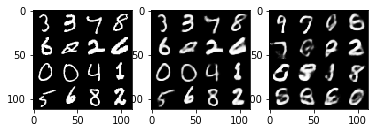

<Epoch:524/1000, Step:465/545>total_loss: 95.4602, kl_loss: 23.8366, recon_loss: 71.6237
<Epoch:525/1000, Step:420/545>total_loss: 97.7157, kl_loss: 24.1225, recon_loss: 73.5932
<Epoch:526/1000, Step:375/545>total_loss: 97.6738, kl_loss: 23.9877, recon_loss: 73.6861
<Epoch:527/1000, Step:330/545>total_loss: 99.3856, kl_loss: 24.3392, recon_loss: 75.0464
<Epoch:528/1000, Step:285/545>total_loss: 98.4717, kl_loss: 24.5226, recon_loss: 73.9491


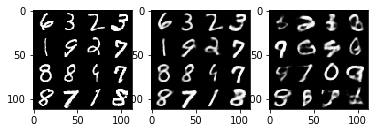

<Epoch:529/1000, Step:240/545>total_loss: 96.7926, kl_loss: 23.8250, recon_loss: 72.9677
<Epoch:530/1000, Step:195/545>total_loss: 96.0322, kl_loss: 24.0786, recon_loss: 71.9535
<Epoch:531/1000, Step:150/545>total_loss: 99.8917, kl_loss: 24.3794, recon_loss: 75.5124
<Epoch:532/1000, Step:105/545>total_loss: 96.7689, kl_loss: 24.0321, recon_loss: 72.7368
<Epoch:533/1000, Step:060/545>total_loss: 98.0840, kl_loss: 24.5089, recon_loss: 73.5750


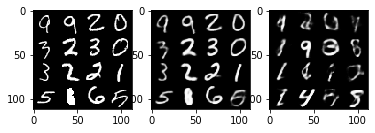

<Epoch:534/1000, Step:015/545>total_loss: 99.2735, kl_loss: 24.6466, recon_loss: 74.6268
<Epoch:534/1000, Step:515/545>total_loss: 96.0761, kl_loss: 23.2526, recon_loss: 72.8235
<Epoch:535/1000, Step:470/545>total_loss: 96.7763, kl_loss: 23.8189, recon_loss: 72.9574
<Epoch:536/1000, Step:425/545>total_loss: 97.7843, kl_loss: 23.7934, recon_loss: 73.9909
<Epoch:537/1000, Step:380/545>total_loss: 100.6019, kl_loss: 24.3275, recon_loss: 76.2744


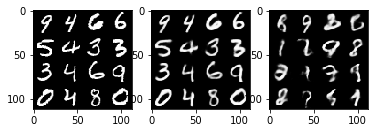

<Epoch:538/1000, Step:335/545>total_loss: 99.0674, kl_loss: 24.2150, recon_loss: 74.8524
<Epoch:539/1000, Step:290/545>total_loss: 99.5712, kl_loss: 24.6147, recon_loss: 74.9565
<Epoch:540/1000, Step:245/545>total_loss: 98.0923, kl_loss: 24.3032, recon_loss: 73.7891
<Epoch:541/1000, Step:200/545>total_loss: 98.1509, kl_loss: 24.6341, recon_loss: 73.5169
<Epoch:542/1000, Step:155/545>total_loss: 96.8155, kl_loss: 23.7198, recon_loss: 73.0957


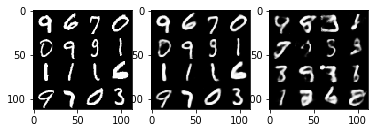

<Epoch:543/1000, Step:110/545>total_loss: 97.5039, kl_loss: 24.2767, recon_loss: 73.2272
<Epoch:544/1000, Step:065/545>total_loss: 103.0801, kl_loss: 24.8432, recon_loss: 78.2370
<Epoch:545/1000, Step:020/545>total_loss: 98.7116, kl_loss: 23.9899, recon_loss: 74.7218
<Epoch:545/1000, Step:520/545>total_loss: 95.5690, kl_loss: 23.5066, recon_loss: 72.0625
<Epoch:546/1000, Step:475/545>total_loss: 97.8290, kl_loss: 24.0953, recon_loss: 73.7337


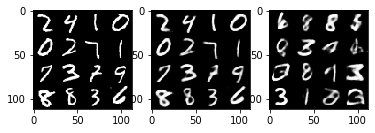

<Epoch:547/1000, Step:430/545>total_loss: 95.1244, kl_loss: 23.8380, recon_loss: 71.2864
<Epoch:548/1000, Step:385/545>total_loss: 99.0777, kl_loss: 24.1753, recon_loss: 74.9023
<Epoch:549/1000, Step:340/545>total_loss: 98.8994, kl_loss: 24.7583, recon_loss: 74.1411
<Epoch:550/1000, Step:295/545>total_loss: 98.1049, kl_loss: 24.3635, recon_loss: 73.7414
<Epoch:551/1000, Step:250/545>total_loss: 98.9415, kl_loss: 24.3612, recon_loss: 74.5803


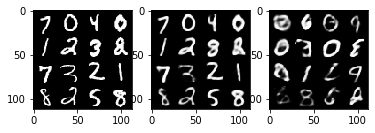

<Epoch:552/1000, Step:205/545>total_loss: 100.2333, kl_loss: 24.1083, recon_loss: 76.1250
<Epoch:553/1000, Step:160/545>total_loss: 101.1566, kl_loss: 24.6304, recon_loss: 76.5262
<Epoch:554/1000, Step:115/545>total_loss: 93.3029, kl_loss: 23.3294, recon_loss: 69.9735
<Epoch:555/1000, Step:070/545>total_loss: 99.3532, kl_loss: 24.2401, recon_loss: 75.1131
<Epoch:556/1000, Step:025/545>total_loss: 98.3892, kl_loss: 24.6408, recon_loss: 73.7484


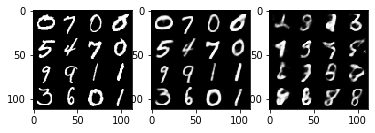

<Epoch:556/1000, Step:525/545>total_loss: 101.0959, kl_loss: 24.9028, recon_loss: 76.1931
<Epoch:557/1000, Step:480/545>total_loss: 97.3332, kl_loss: 23.6728, recon_loss: 73.6604
<Epoch:558/1000, Step:435/545>total_loss: 95.2162, kl_loss: 23.6104, recon_loss: 71.6059
<Epoch:559/1000, Step:390/545>total_loss: 99.3698, kl_loss: 24.1945, recon_loss: 75.1753
<Epoch:560/1000, Step:345/545>total_loss: 99.4732, kl_loss: 24.2196, recon_loss: 75.2536


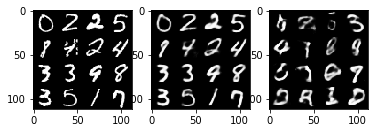

<Epoch:561/1000, Step:300/545>total_loss: 98.9311, kl_loss: 24.5414, recon_loss: 74.3897
<Epoch:562/1000, Step:255/545>total_loss: 93.5653, kl_loss: 23.2912, recon_loss: 70.2741
<Epoch:563/1000, Step:210/545>total_loss: 96.5891, kl_loss: 24.2750, recon_loss: 72.3141
<Epoch:564/1000, Step:165/545>total_loss: 96.3388, kl_loss: 24.3843, recon_loss: 71.9545
<Epoch:565/1000, Step:120/545>total_loss: 97.5900, kl_loss: 23.9342, recon_loss: 73.6557


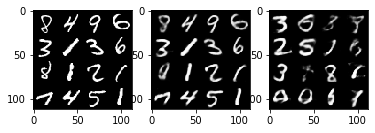

<Epoch:566/1000, Step:075/545>total_loss: 101.6680, kl_loss: 24.1271, recon_loss: 77.5410
<Epoch:567/1000, Step:030/545>total_loss: 98.0368, kl_loss: 24.5033, recon_loss: 73.5335
<Epoch:567/1000, Step:530/545>total_loss: 98.4827, kl_loss: 24.5678, recon_loss: 73.9150
<Epoch:568/1000, Step:485/545>total_loss: 97.9630, kl_loss: 24.1342, recon_loss: 73.8288
<Epoch:569/1000, Step:440/545>total_loss: 96.0219, kl_loss: 23.3744, recon_loss: 72.6475


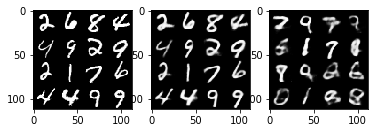

<Epoch:570/1000, Step:395/545>total_loss: 95.9954, kl_loss: 24.1732, recon_loss: 71.8222
<Epoch:571/1000, Step:350/545>total_loss: 99.2731, kl_loss: 23.9312, recon_loss: 75.3418
<Epoch:572/1000, Step:305/545>total_loss: 100.9366, kl_loss: 24.4065, recon_loss: 76.5301
<Epoch:573/1000, Step:260/545>total_loss: 96.4812, kl_loss: 23.9778, recon_loss: 72.5034
<Epoch:574/1000, Step:215/545>total_loss: 94.5096, kl_loss: 24.1546, recon_loss: 70.3550


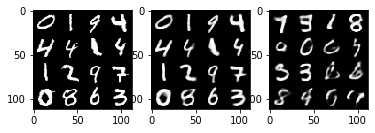

<Epoch:575/1000, Step:170/545>total_loss: 95.3539, kl_loss: 23.6683, recon_loss: 71.6856
<Epoch:576/1000, Step:125/545>total_loss: 97.6241, kl_loss: 24.5811, recon_loss: 73.0430
<Epoch:577/1000, Step:080/545>total_loss: 95.1715, kl_loss: 23.9601, recon_loss: 71.2114
<Epoch:578/1000, Step:035/545>total_loss: 101.1829, kl_loss: 24.6478, recon_loss: 76.5351
<Epoch:578/1000, Step:535/545>total_loss: 97.9188, kl_loss: 24.2188, recon_loss: 73.7000


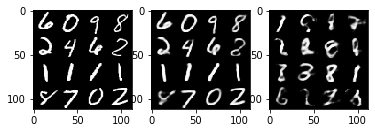

<Epoch:579/1000, Step:490/545>total_loss: 94.3763, kl_loss: 23.6087, recon_loss: 70.7675
<Epoch:580/1000, Step:445/545>total_loss: 98.5023, kl_loss: 24.2130, recon_loss: 74.2893
<Epoch:581/1000, Step:400/545>total_loss: 96.8075, kl_loss: 24.1487, recon_loss: 72.6588
<Epoch:582/1000, Step:355/545>total_loss: 99.3599, kl_loss: 24.0958, recon_loss: 75.2641
<Epoch:583/1000, Step:310/545>total_loss: 98.2906, kl_loss: 24.1633, recon_loss: 74.1274


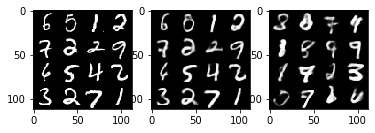

<Epoch:584/1000, Step:265/545>total_loss: 95.5883, kl_loss: 23.9971, recon_loss: 71.5912
<Epoch:585/1000, Step:220/545>total_loss: 98.4571, kl_loss: 24.0764, recon_loss: 74.3807
<Epoch:586/1000, Step:175/545>total_loss: 95.6328, kl_loss: 24.0184, recon_loss: 71.6145
<Epoch:587/1000, Step:130/545>total_loss: 97.0401, kl_loss: 24.5427, recon_loss: 72.4975
<Epoch:588/1000, Step:085/545>total_loss: 99.5168, kl_loss: 23.8993, recon_loss: 75.6175


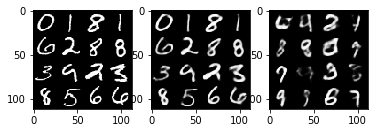

<Epoch:589/1000, Step:040/545>total_loss: 97.1101, kl_loss: 23.7178, recon_loss: 73.3924
<Epoch:589/1000, Step:540/545>total_loss: 97.9755, kl_loss: 24.4054, recon_loss: 73.5701
<Epoch:590/1000, Step:495/545>total_loss: 97.9339, kl_loss: 24.6843, recon_loss: 73.2497
<Epoch:591/1000, Step:450/545>total_loss: 98.3865, kl_loss: 23.9582, recon_loss: 74.4283
<Epoch:592/1000, Step:405/545>total_loss: 98.9650, kl_loss: 23.8568, recon_loss: 75.1082


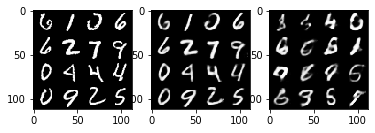

<Epoch:593/1000, Step:360/545>total_loss: 96.4400, kl_loss: 23.9454, recon_loss: 72.4946
<Epoch:594/1000, Step:315/545>total_loss: 96.8959, kl_loss: 24.2416, recon_loss: 72.6543
<Epoch:595/1000, Step:270/545>total_loss: 100.5366, kl_loss: 24.4066, recon_loss: 76.1299
<Epoch:596/1000, Step:225/545>total_loss: 95.3340, kl_loss: 23.9404, recon_loss: 71.3937
<Epoch:597/1000, Step:180/545>total_loss: 102.7693, kl_loss: 25.0046, recon_loss: 77.7647


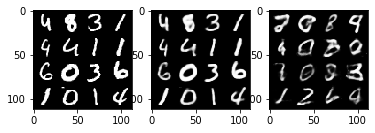

<Epoch:598/1000, Step:135/545>total_loss: 97.5207, kl_loss: 24.3844, recon_loss: 73.1362
<Epoch:599/1000, Step:090/545>total_loss: 98.3200, kl_loss: 24.3126, recon_loss: 74.0073
<Epoch:600/1000, Step:045/545>total_loss: 99.0374, kl_loss: 24.4405, recon_loss: 74.5968
<Epoch:600/1000, Step:545/545>total_loss: 101.8032, kl_loss: 24.6028, recon_loss: 77.2003
<Epoch:601/1000, Step:500/545>total_loss: 101.3703, kl_loss: 24.5364, recon_loss: 76.8339


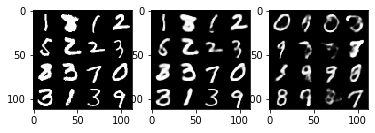

<Epoch:602/1000, Step:455/545>total_loss: 96.2401, kl_loss: 24.5702, recon_loss: 71.6699
<Epoch:603/1000, Step:410/545>total_loss: 95.0790, kl_loss: 23.5878, recon_loss: 71.4913
<Epoch:604/1000, Step:365/545>total_loss: 96.8734, kl_loss: 24.0687, recon_loss: 72.8047
<Epoch:605/1000, Step:320/545>total_loss: 98.8474, kl_loss: 24.4359, recon_loss: 74.4115
<Epoch:606/1000, Step:275/545>total_loss: 98.4020, kl_loss: 24.0285, recon_loss: 74.3735


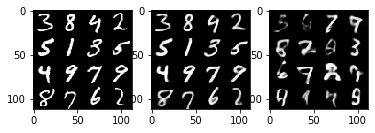

<Epoch:607/1000, Step:230/545>total_loss: 99.4743, kl_loss: 24.7179, recon_loss: 74.7563
<Epoch:608/1000, Step:185/545>total_loss: 99.7100, kl_loss: 24.3656, recon_loss: 75.3444
<Epoch:609/1000, Step:140/545>total_loss: 100.1801, kl_loss: 24.6047, recon_loss: 75.5753
<Epoch:610/1000, Step:095/545>total_loss: 96.4755, kl_loss: 24.2995, recon_loss: 72.1760
<Epoch:611/1000, Step:050/545>total_loss: 97.5398, kl_loss: 23.9350, recon_loss: 73.6048


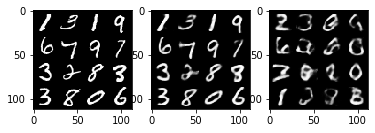

<Epoch:612/1000, Step:005/545>total_loss: 98.1382, kl_loss: 24.2849, recon_loss: 73.8533
<Epoch:612/1000, Step:505/545>total_loss: 101.0945, kl_loss: 24.2720, recon_loss: 76.8225
<Epoch:613/1000, Step:460/545>total_loss: 100.2501, kl_loss: 24.4971, recon_loss: 75.7530
<Epoch:614/1000, Step:415/545>total_loss: 97.0086, kl_loss: 24.1029, recon_loss: 72.9057
<Epoch:615/1000, Step:370/545>total_loss: 98.8479, kl_loss: 24.1469, recon_loss: 74.7009


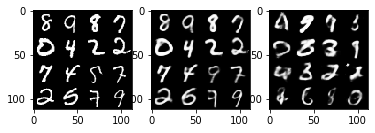

<Epoch:616/1000, Step:325/545>total_loss: 98.6295, kl_loss: 24.0169, recon_loss: 74.6126
<Epoch:617/1000, Step:280/545>total_loss: 102.7171, kl_loss: 25.1813, recon_loss: 77.5358
<Epoch:618/1000, Step:235/545>total_loss: 97.0505, kl_loss: 23.7699, recon_loss: 73.2806
<Epoch:619/1000, Step:190/545>total_loss: 98.9490, kl_loss: 24.4736, recon_loss: 74.4755
<Epoch:620/1000, Step:145/545>total_loss: 97.9100, kl_loss: 24.1542, recon_loss: 73.7558


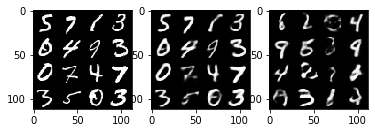

<Epoch:621/1000, Step:100/545>total_loss: 101.0222, kl_loss: 24.3909, recon_loss: 76.6313
<Epoch:622/1000, Step:055/545>total_loss: 95.1932, kl_loss: 24.1269, recon_loss: 71.0663
<Epoch:623/1000, Step:010/545>total_loss: 95.8032, kl_loss: 23.7996, recon_loss: 72.0035
<Epoch:623/1000, Step:510/545>total_loss: 96.6908, kl_loss: 24.3850, recon_loss: 72.3058
<Epoch:624/1000, Step:465/545>total_loss: 100.0949, kl_loss: 24.5421, recon_loss: 75.5527


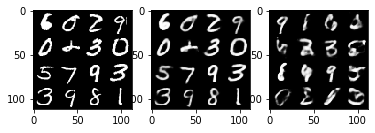

<Epoch:625/1000, Step:420/545>total_loss: 98.7004, kl_loss: 24.2515, recon_loss: 74.4489
<Epoch:626/1000, Step:375/545>total_loss: 96.2328, kl_loss: 23.9355, recon_loss: 72.2974
<Epoch:627/1000, Step:330/545>total_loss: 96.5995, kl_loss: 24.4109, recon_loss: 72.1886
<Epoch:628/1000, Step:285/545>total_loss: 96.4156, kl_loss: 23.6863, recon_loss: 72.7293
<Epoch:629/1000, Step:240/545>total_loss: 97.4249, kl_loss: 24.0628, recon_loss: 73.3621


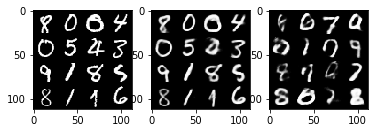

<Epoch:630/1000, Step:195/545>total_loss: 94.1879, kl_loss: 24.1928, recon_loss: 69.9951
<Epoch:631/1000, Step:150/545>total_loss: 92.8727, kl_loss: 23.4369, recon_loss: 69.4359
<Epoch:632/1000, Step:105/545>total_loss: 97.0474, kl_loss: 24.1847, recon_loss: 72.8628
<Epoch:633/1000, Step:060/545>total_loss: 97.9924, kl_loss: 24.0498, recon_loss: 73.9425
<Epoch:634/1000, Step:015/545>total_loss: 98.1065, kl_loss: 24.5827, recon_loss: 73.5238


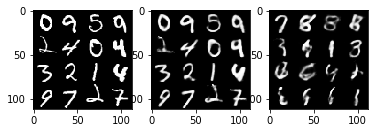

<Epoch:634/1000, Step:515/545>total_loss: 98.9856, kl_loss: 24.5569, recon_loss: 74.4287
<Epoch:635/1000, Step:470/545>total_loss: 100.7386, kl_loss: 24.4187, recon_loss: 76.3199
<Epoch:636/1000, Step:425/545>total_loss: 99.9314, kl_loss: 24.3273, recon_loss: 75.6040
<Epoch:637/1000, Step:380/545>total_loss: 94.7492, kl_loss: 23.6266, recon_loss: 71.1227
<Epoch:638/1000, Step:335/545>total_loss: 100.4388, kl_loss: 24.4876, recon_loss: 75.9512


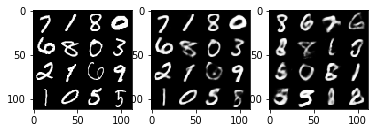

<Epoch:639/1000, Step:290/545>total_loss: 96.7331, kl_loss: 23.7492, recon_loss: 72.9839
<Epoch:640/1000, Step:245/545>total_loss: 99.8981, kl_loss: 24.5792, recon_loss: 75.3189
<Epoch:641/1000, Step:200/545>total_loss: 95.0618, kl_loss: 23.6356, recon_loss: 71.4263
<Epoch:642/1000, Step:155/545>total_loss: 94.9378, kl_loss: 23.8883, recon_loss: 71.0495
<Epoch:643/1000, Step:110/545>total_loss: 98.5811, kl_loss: 24.5953, recon_loss: 73.9858


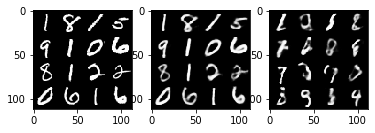

<Epoch:644/1000, Step:065/545>total_loss: 101.1965, kl_loss: 24.9954, recon_loss: 76.2010
<Epoch:645/1000, Step:020/545>total_loss: 99.2122, kl_loss: 24.5016, recon_loss: 74.7106
<Epoch:645/1000, Step:520/545>total_loss: 98.8392, kl_loss: 24.7838, recon_loss: 74.0554
<Epoch:646/1000, Step:475/545>total_loss: 99.3460, kl_loss: 24.8424, recon_loss: 74.5036
<Epoch:647/1000, Step:430/545>total_loss: 98.0853, kl_loss: 24.5330, recon_loss: 73.5523


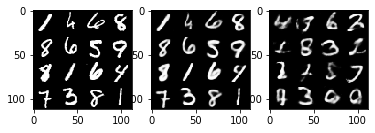

<Epoch:648/1000, Step:385/545>total_loss: 95.0265, kl_loss: 23.8257, recon_loss: 71.2008
<Epoch:649/1000, Step:340/545>total_loss: 95.8449, kl_loss: 23.6872, recon_loss: 72.1577
<Epoch:650/1000, Step:295/545>total_loss: 98.1143, kl_loss: 23.9792, recon_loss: 74.1351
<Epoch:651/1000, Step:250/545>total_loss: 99.9593, kl_loss: 24.4328, recon_loss: 75.5265
<Epoch:652/1000, Step:205/545>total_loss: 96.4203, kl_loss: 23.7634, recon_loss: 72.6569


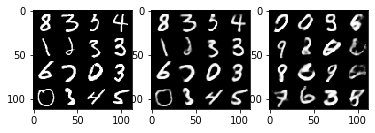

<Epoch:653/1000, Step:160/545>total_loss: 98.1920, kl_loss: 24.3910, recon_loss: 73.8010
<Epoch:654/1000, Step:115/545>total_loss: 97.0226, kl_loss: 23.8484, recon_loss: 73.1742
<Epoch:655/1000, Step:070/545>total_loss: 98.6435, kl_loss: 24.1024, recon_loss: 74.5411
<Epoch:656/1000, Step:025/545>total_loss: 96.3928, kl_loss: 24.2357, recon_loss: 72.1571
<Epoch:656/1000, Step:525/545>total_loss: 100.1786, kl_loss: 24.4831, recon_loss: 75.6954


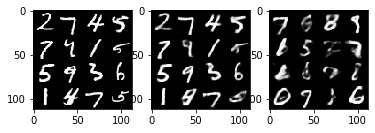

<Epoch:657/1000, Step:480/545>total_loss: 94.5578, kl_loss: 23.5048, recon_loss: 71.0530
<Epoch:658/1000, Step:435/545>total_loss: 98.4026, kl_loss: 24.1381, recon_loss: 74.2645
<Epoch:659/1000, Step:390/545>total_loss: 99.2300, kl_loss: 24.3029, recon_loss: 74.9271
<Epoch:660/1000, Step:345/545>total_loss: 97.9579, kl_loss: 24.3069, recon_loss: 73.6511
<Epoch:661/1000, Step:300/545>total_loss: 95.3592, kl_loss: 23.4112, recon_loss: 71.9480


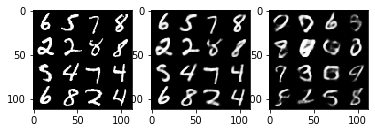

<Epoch:662/1000, Step:255/545>total_loss: 94.5060, kl_loss: 23.7204, recon_loss: 70.7855
<Epoch:663/1000, Step:210/545>total_loss: 98.2812, kl_loss: 23.9959, recon_loss: 74.2852
<Epoch:664/1000, Step:165/545>total_loss: 98.7903, kl_loss: 24.3693, recon_loss: 74.4210
<Epoch:665/1000, Step:120/545>total_loss: 97.9214, kl_loss: 24.6458, recon_loss: 73.2756
<Epoch:666/1000, Step:075/545>total_loss: 97.8710, kl_loss: 24.0084, recon_loss: 73.8626


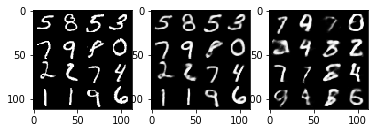

<Epoch:667/1000, Step:030/545>total_loss: 101.5175, kl_loss: 24.7710, recon_loss: 76.7465
<Epoch:667/1000, Step:530/545>total_loss: 95.9859, kl_loss: 23.5721, recon_loss: 72.4139
<Epoch:668/1000, Step:485/545>total_loss: 101.1046, kl_loss: 24.6687, recon_loss: 76.4360
<Epoch:669/1000, Step:440/545>total_loss: 94.5141, kl_loss: 23.6754, recon_loss: 70.8387
<Epoch:670/1000, Step:395/545>total_loss: 99.2902, kl_loss: 24.4731, recon_loss: 74.8172


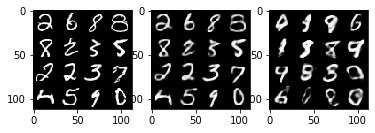

<Epoch:671/1000, Step:350/545>total_loss: 99.7796, kl_loss: 24.8718, recon_loss: 74.9078
<Epoch:672/1000, Step:305/545>total_loss: 100.6514, kl_loss: 24.5567, recon_loss: 76.0947
<Epoch:673/1000, Step:260/545>total_loss: 98.2039, kl_loss: 24.1100, recon_loss: 74.0939
<Epoch:674/1000, Step:215/545>total_loss: 99.2981, kl_loss: 24.3753, recon_loss: 74.9229
<Epoch:675/1000, Step:170/545>total_loss: 100.4915, kl_loss: 24.6700, recon_loss: 75.8216


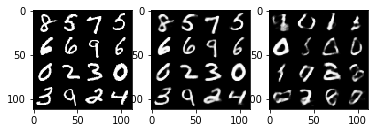

<Epoch:676/1000, Step:125/545>total_loss: 100.6274, kl_loss: 24.8963, recon_loss: 75.7311
<Epoch:677/1000, Step:080/545>total_loss: 98.3861, kl_loss: 24.3786, recon_loss: 74.0076
<Epoch:678/1000, Step:035/545>total_loss: 98.2103, kl_loss: 24.8158, recon_loss: 73.3945
<Epoch:678/1000, Step:535/545>total_loss: 98.0934, kl_loss: 23.9293, recon_loss: 74.1641
<Epoch:679/1000, Step:490/545>total_loss: 98.3226, kl_loss: 24.2302, recon_loss: 74.0924


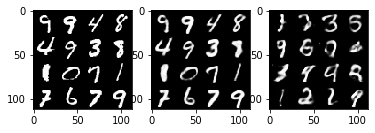

<Epoch:680/1000, Step:445/545>total_loss: 98.0412, kl_loss: 24.0235, recon_loss: 74.0177
<Epoch:681/1000, Step:400/545>total_loss: 101.4361, kl_loss: 24.7552, recon_loss: 76.6808
<Epoch:682/1000, Step:355/545>total_loss: 98.9300, kl_loss: 24.3533, recon_loss: 74.5766
<Epoch:683/1000, Step:310/545>total_loss: 99.9312, kl_loss: 24.3768, recon_loss: 75.5544
<Epoch:684/1000, Step:265/545>total_loss: 99.6797, kl_loss: 24.6607, recon_loss: 75.0190


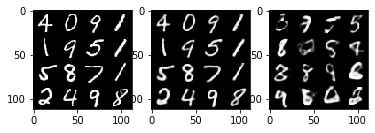

<Epoch:685/1000, Step:220/545>total_loss: 95.9696, kl_loss: 23.9358, recon_loss: 72.0339
<Epoch:686/1000, Step:175/545>total_loss: 98.0151, kl_loss: 24.4577, recon_loss: 73.5574
<Epoch:687/1000, Step:130/545>total_loss: 96.6595, kl_loss: 23.7528, recon_loss: 72.9067
<Epoch:688/1000, Step:085/545>total_loss: 101.3750, kl_loss: 24.6899, recon_loss: 76.6851
<Epoch:689/1000, Step:040/545>total_loss: 97.7961, kl_loss: 24.2130, recon_loss: 73.5831


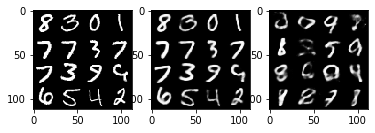

<Epoch:689/1000, Step:540/545>total_loss: 98.5310, kl_loss: 24.4886, recon_loss: 74.0424
<Epoch:690/1000, Step:495/545>total_loss: 98.2121, kl_loss: 24.4331, recon_loss: 73.7790
<Epoch:691/1000, Step:450/545>total_loss: 98.1987, kl_loss: 24.4317, recon_loss: 73.7670
<Epoch:692/1000, Step:405/545>total_loss: 96.5328, kl_loss: 24.1099, recon_loss: 72.4230
<Epoch:693/1000, Step:360/545>total_loss: 94.0667, kl_loss: 23.8478, recon_loss: 70.2189


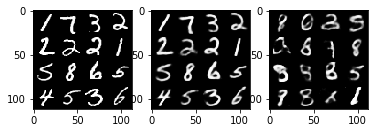

<Epoch:694/1000, Step:315/545>total_loss: 94.8114, kl_loss: 23.6975, recon_loss: 71.1140
<Epoch:695/1000, Step:270/545>total_loss: 97.4113, kl_loss: 24.5752, recon_loss: 72.8362
<Epoch:696/1000, Step:225/545>total_loss: 96.9945, kl_loss: 24.0827, recon_loss: 72.9117
<Epoch:697/1000, Step:180/545>total_loss: 98.3956, kl_loss: 24.4920, recon_loss: 73.9037
<Epoch:698/1000, Step:135/545>total_loss: 98.0239, kl_loss: 24.2406, recon_loss: 73.7834


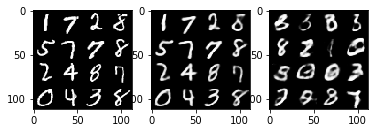

<Epoch:699/1000, Step:090/545>total_loss: 102.8005, kl_loss: 24.4229, recon_loss: 78.3776
<Epoch:700/1000, Step:045/545>total_loss: 97.5298, kl_loss: 23.9482, recon_loss: 73.5816
<Epoch:700/1000, Step:545/545>total_loss: 97.8338, kl_loss: 24.4075, recon_loss: 73.4263
<Epoch:701/1000, Step:500/545>total_loss: 96.2996, kl_loss: 24.0782, recon_loss: 72.2213
<Epoch:702/1000, Step:455/545>total_loss: 92.9137, kl_loss: 23.6770, recon_loss: 69.2367


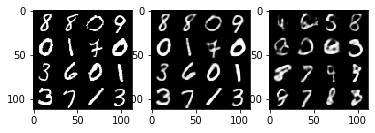

<Epoch:703/1000, Step:410/545>total_loss: 99.0315, kl_loss: 24.4292, recon_loss: 74.6023
<Epoch:704/1000, Step:365/545>total_loss: 94.8661, kl_loss: 23.5418, recon_loss: 71.3243
<Epoch:705/1000, Step:320/545>total_loss: 99.5557, kl_loss: 24.4229, recon_loss: 75.1329
<Epoch:706/1000, Step:275/545>total_loss: 100.9111, kl_loss: 24.6527, recon_loss: 76.2584
<Epoch:707/1000, Step:230/545>total_loss: 97.7492, kl_loss: 24.0146, recon_loss: 73.7346


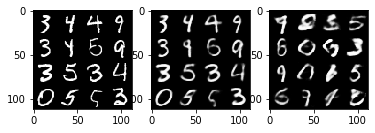

<Epoch:708/1000, Step:185/545>total_loss: 96.8916, kl_loss: 23.9549, recon_loss: 72.9367
<Epoch:709/1000, Step:140/545>total_loss: 99.6484, kl_loss: 23.6643, recon_loss: 75.9841
<Epoch:710/1000, Step:095/545>total_loss: 97.0339, kl_loss: 24.4313, recon_loss: 72.6026
<Epoch:711/1000, Step:050/545>total_loss: 100.1784, kl_loss: 24.8328, recon_loss: 75.3456
<Epoch:712/1000, Step:005/545>total_loss: 98.7747, kl_loss: 24.2876, recon_loss: 74.4871


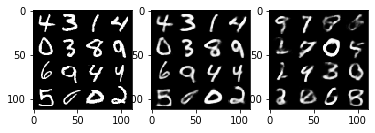

<Epoch:712/1000, Step:505/545>total_loss: 95.8965, kl_loss: 23.7670, recon_loss: 72.1295
<Epoch:713/1000, Step:460/545>total_loss: 100.4758, kl_loss: 24.7935, recon_loss: 75.6823
<Epoch:714/1000, Step:415/545>total_loss: 97.7439, kl_loss: 23.9079, recon_loss: 73.8360
<Epoch:715/1000, Step:370/545>total_loss: 100.3310, kl_loss: 24.2991, recon_loss: 76.0319
<Epoch:716/1000, Step:325/545>total_loss: 97.7110, kl_loss: 23.9785, recon_loss: 73.7324


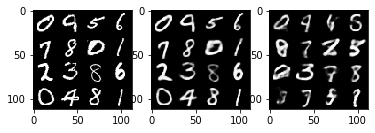

<Epoch:717/1000, Step:280/545>total_loss: 101.3224, kl_loss: 24.6733, recon_loss: 76.6491
<Epoch:718/1000, Step:235/545>total_loss: 98.1856, kl_loss: 24.6129, recon_loss: 73.5726
<Epoch:719/1000, Step:190/545>total_loss: 98.6006, kl_loss: 23.6933, recon_loss: 74.9073
<Epoch:720/1000, Step:145/545>total_loss: 94.7064, kl_loss: 23.7345, recon_loss: 70.9719
<Epoch:721/1000, Step:100/545>total_loss: 102.2925, kl_loss: 24.8296, recon_loss: 77.4629


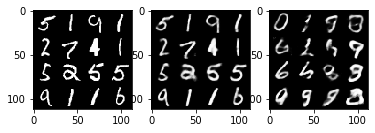

<Epoch:722/1000, Step:055/545>total_loss: 101.7876, kl_loss: 24.7810, recon_loss: 77.0066
<Epoch:723/1000, Step:010/545>total_loss: 92.5584, kl_loss: 23.3354, recon_loss: 69.2230
<Epoch:723/1000, Step:510/545>total_loss: 95.6122, kl_loss: 23.5336, recon_loss: 72.0786
<Epoch:724/1000, Step:465/545>total_loss: 95.5094, kl_loss: 23.9925, recon_loss: 71.5169
<Epoch:725/1000, Step:420/545>total_loss: 99.5628, kl_loss: 24.0167, recon_loss: 75.5461


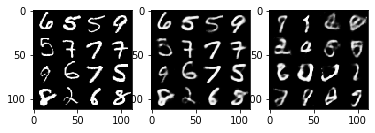

<Epoch:726/1000, Step:375/545>total_loss: 100.7279, kl_loss: 24.6649, recon_loss: 76.0629
<Epoch:727/1000, Step:330/545>total_loss: 99.0487, kl_loss: 24.6260, recon_loss: 74.4227
<Epoch:728/1000, Step:285/545>total_loss: 98.5878, kl_loss: 24.1793, recon_loss: 74.4085
<Epoch:729/1000, Step:240/545>total_loss: 97.2202, kl_loss: 24.2971, recon_loss: 72.9230
<Epoch:730/1000, Step:195/545>total_loss: 98.2344, kl_loss: 24.3976, recon_loss: 73.8368


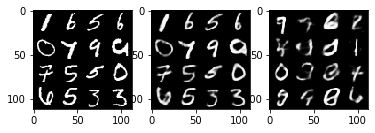

<Epoch:731/1000, Step:150/545>total_loss: 97.0759, kl_loss: 24.2621, recon_loss: 72.8138
<Epoch:732/1000, Step:105/545>total_loss: 99.8038, kl_loss: 24.4408, recon_loss: 75.3629
<Epoch:733/1000, Step:060/545>total_loss: 96.9118, kl_loss: 24.4025, recon_loss: 72.5093
<Epoch:734/1000, Step:015/545>total_loss: 99.2191, kl_loss: 24.7188, recon_loss: 74.5003
<Epoch:734/1000, Step:515/545>total_loss: 97.6603, kl_loss: 24.3855, recon_loss: 73.2748


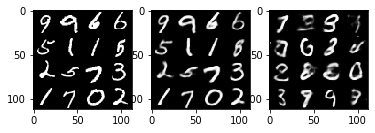

<Epoch:735/1000, Step:470/545>total_loss: 100.2575, kl_loss: 24.2792, recon_loss: 75.9783
<Epoch:736/1000, Step:425/545>total_loss: 97.8980, kl_loss: 23.9158, recon_loss: 73.9822
<Epoch:737/1000, Step:380/545>total_loss: 99.5935, kl_loss: 24.5691, recon_loss: 75.0244
<Epoch:738/1000, Step:335/545>total_loss: 99.1241, kl_loss: 24.3315, recon_loss: 74.7926
<Epoch:739/1000, Step:290/545>total_loss: 98.2281, kl_loss: 24.3886, recon_loss: 73.8394


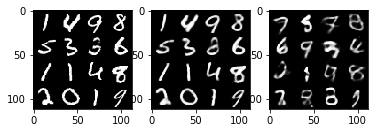

<Epoch:740/1000, Step:245/545>total_loss: 98.5563, kl_loss: 24.6841, recon_loss: 73.8722
<Epoch:741/1000, Step:200/545>total_loss: 98.0636, kl_loss: 24.1471, recon_loss: 73.9165
<Epoch:742/1000, Step:155/545>total_loss: 97.6904, kl_loss: 24.0026, recon_loss: 73.6878
<Epoch:743/1000, Step:110/545>total_loss: 99.8453, kl_loss: 24.7592, recon_loss: 75.0861
<Epoch:744/1000, Step:065/545>total_loss: 100.9549, kl_loss: 24.2084, recon_loss: 76.7464


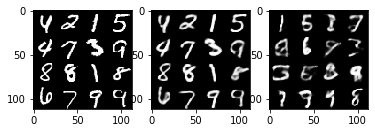

<Epoch:745/1000, Step:020/545>total_loss: 99.4216, kl_loss: 24.5012, recon_loss: 74.9205
<Epoch:745/1000, Step:520/545>total_loss: 97.1504, kl_loss: 24.2492, recon_loss: 72.9012
<Epoch:746/1000, Step:475/545>total_loss: 95.6772, kl_loss: 23.2338, recon_loss: 72.4433
<Epoch:747/1000, Step:430/545>total_loss: 100.0063, kl_loss: 24.6367, recon_loss: 75.3696
<Epoch:748/1000, Step:385/545>total_loss: 96.5403, kl_loss: 23.9866, recon_loss: 72.5537


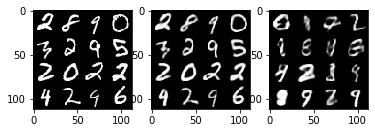

<Epoch:749/1000, Step:340/545>total_loss: 94.0348, kl_loss: 23.6363, recon_loss: 70.3985
<Epoch:750/1000, Step:295/545>total_loss: 96.0205, kl_loss: 23.5890, recon_loss: 72.4314
<Epoch:751/1000, Step:250/545>total_loss: 96.8842, kl_loss: 23.6799, recon_loss: 73.2043
<Epoch:752/1000, Step:205/545>total_loss: 99.9439, kl_loss: 24.5747, recon_loss: 75.3691
<Epoch:753/1000, Step:160/545>total_loss: 96.2674, kl_loss: 24.0954, recon_loss: 72.1720


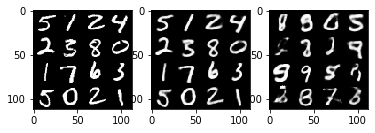

<Epoch:754/1000, Step:115/545>total_loss: 97.0060, kl_loss: 23.9411, recon_loss: 73.0649
<Epoch:755/1000, Step:070/545>total_loss: 96.2321, kl_loss: 24.2647, recon_loss: 71.9674
<Epoch:756/1000, Step:025/545>total_loss: 98.5444, kl_loss: 24.0494, recon_loss: 74.4950
<Epoch:756/1000, Step:525/545>total_loss: 97.1700, kl_loss: 24.1838, recon_loss: 72.9862
<Epoch:757/1000, Step:480/545>total_loss: 94.4093, kl_loss: 23.7314, recon_loss: 70.6779


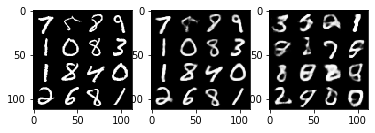

<Epoch:758/1000, Step:435/545>total_loss: 99.8195, kl_loss: 24.2923, recon_loss: 75.5272
<Epoch:759/1000, Step:390/545>total_loss: 93.9729, kl_loss: 23.9002, recon_loss: 70.0726
<Epoch:760/1000, Step:345/545>total_loss: 97.8345, kl_loss: 24.1172, recon_loss: 73.7174
<Epoch:761/1000, Step:300/545>total_loss: 95.9413, kl_loss: 23.8418, recon_loss: 72.0995
<Epoch:762/1000, Step:255/545>total_loss: 95.2548, kl_loss: 23.6732, recon_loss: 71.5816


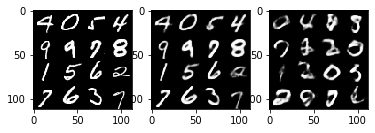

<Epoch:763/1000, Step:210/545>total_loss: 98.6821, kl_loss: 24.2618, recon_loss: 74.4204
<Epoch:764/1000, Step:165/545>total_loss: 99.9272, kl_loss: 23.9662, recon_loss: 75.9610
<Epoch:765/1000, Step:120/545>total_loss: 96.2425, kl_loss: 24.2149, recon_loss: 72.0276
<Epoch:766/1000, Step:075/545>total_loss: 96.9429, kl_loss: 24.1993, recon_loss: 72.7436
<Epoch:767/1000, Step:030/545>total_loss: 98.6653, kl_loss: 24.7085, recon_loss: 73.9568


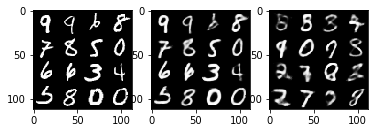

<Epoch:767/1000, Step:530/545>total_loss: 98.1530, kl_loss: 24.1151, recon_loss: 74.0379
<Epoch:768/1000, Step:485/545>total_loss: 96.8184, kl_loss: 23.8741, recon_loss: 72.9443
<Epoch:769/1000, Step:440/545>total_loss: 95.5912, kl_loss: 23.5020, recon_loss: 72.0892
<Epoch:770/1000, Step:395/545>total_loss: 95.1801, kl_loss: 24.0011, recon_loss: 71.1790
<Epoch:771/1000, Step:350/545>total_loss: 97.5143, kl_loss: 24.1284, recon_loss: 73.3859


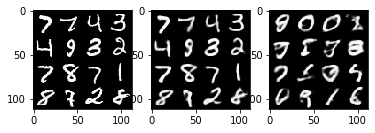

<Epoch:772/1000, Step:305/545>total_loss: 98.5228, kl_loss: 24.3123, recon_loss: 74.2106
<Epoch:773/1000, Step:260/545>total_loss: 95.0146, kl_loss: 23.4654, recon_loss: 71.5492
<Epoch:774/1000, Step:215/545>total_loss: 102.0300, kl_loss: 24.8045, recon_loss: 77.2255
<Epoch:775/1000, Step:170/545>total_loss: 97.6328, kl_loss: 24.0169, recon_loss: 73.6160
<Epoch:776/1000, Step:125/545>total_loss: 98.4727, kl_loss: 24.4764, recon_loss: 73.9963


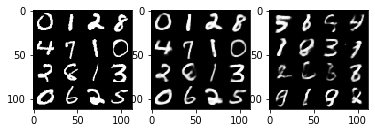

<Epoch:777/1000, Step:080/545>total_loss: 99.3365, kl_loss: 24.2592, recon_loss: 75.0772
<Epoch:778/1000, Step:035/545>total_loss: 98.9668, kl_loss: 24.4456, recon_loss: 74.5212
<Epoch:778/1000, Step:535/545>total_loss: 96.0207, kl_loss: 23.9375, recon_loss: 72.0833
<Epoch:779/1000, Step:490/545>total_loss: 95.8338, kl_loss: 24.3498, recon_loss: 71.4839
<Epoch:780/1000, Step:445/545>total_loss: 100.0297, kl_loss: 24.8042, recon_loss: 75.2255


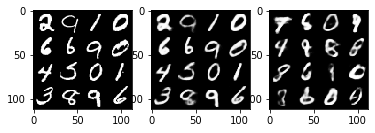

<Epoch:781/1000, Step:400/545>total_loss: 97.0863, kl_loss: 23.8802, recon_loss: 73.2061
<Epoch:782/1000, Step:355/545>total_loss: 97.7100, kl_loss: 23.8047, recon_loss: 73.9053
<Epoch:783/1000, Step:310/545>total_loss: 98.3099, kl_loss: 24.3004, recon_loss: 74.0096
<Epoch:784/1000, Step:265/545>total_loss: 98.7701, kl_loss: 24.3541, recon_loss: 74.4161
<Epoch:785/1000, Step:220/545>total_loss: 97.1505, kl_loss: 24.1901, recon_loss: 72.9604


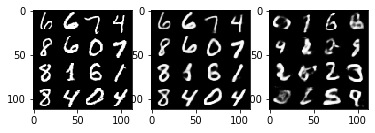

<Epoch:786/1000, Step:175/545>total_loss: 96.8809, kl_loss: 23.9561, recon_loss: 72.9248
<Epoch:787/1000, Step:130/545>total_loss: 96.4626, kl_loss: 23.8732, recon_loss: 72.5894
<Epoch:788/1000, Step:085/545>total_loss: 100.5157, kl_loss: 24.2100, recon_loss: 76.3057
<Epoch:789/1000, Step:040/545>total_loss: 95.2961, kl_loss: 24.2587, recon_loss: 71.0374
<Epoch:789/1000, Step:540/545>total_loss: 97.1277, kl_loss: 23.7476, recon_loss: 73.3801


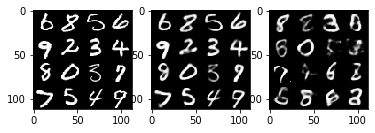

<Epoch:790/1000, Step:495/545>total_loss: 93.4216, kl_loss: 23.3650, recon_loss: 70.0566
<Epoch:791/1000, Step:450/545>total_loss: 98.0257, kl_loss: 24.6023, recon_loss: 73.4234
<Epoch:792/1000, Step:405/545>total_loss: 101.0184, kl_loss: 25.0503, recon_loss: 75.9682
<Epoch:793/1000, Step:360/545>total_loss: 96.1951, kl_loss: 23.8503, recon_loss: 72.3448
<Epoch:794/1000, Step:315/545>total_loss: 95.4817, kl_loss: 24.0466, recon_loss: 71.4350


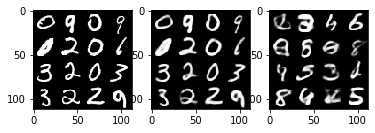

<Epoch:795/1000, Step:270/545>total_loss: 95.6963, kl_loss: 23.9549, recon_loss: 71.7413
<Epoch:796/1000, Step:225/545>total_loss: 96.7811, kl_loss: 24.1014, recon_loss: 72.6797
<Epoch:797/1000, Step:180/545>total_loss: 98.6771, kl_loss: 24.4289, recon_loss: 74.2482
<Epoch:798/1000, Step:135/545>total_loss: 100.7138, kl_loss: 24.7247, recon_loss: 75.9891
<Epoch:799/1000, Step:090/545>total_loss: 95.1378, kl_loss: 24.1466, recon_loss: 70.9912


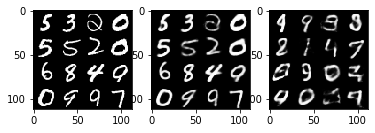

<Epoch:800/1000, Step:045/545>total_loss: 99.2456, kl_loss: 24.3420, recon_loss: 74.9036
<Epoch:800/1000, Step:545/545>total_loss: 97.9380, kl_loss: 24.1597, recon_loss: 73.7783
<Epoch:801/1000, Step:500/545>total_loss: 95.6703, kl_loss: 23.4761, recon_loss: 72.1942
<Epoch:802/1000, Step:455/545>total_loss: 99.5633, kl_loss: 24.5015, recon_loss: 75.0618
<Epoch:803/1000, Step:410/545>total_loss: 95.1372, kl_loss: 23.5865, recon_loss: 71.5506


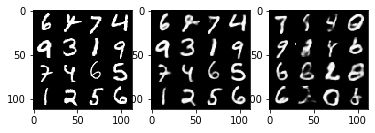

<Epoch:804/1000, Step:365/545>total_loss: 96.8911, kl_loss: 24.1957, recon_loss: 72.6953
<Epoch:805/1000, Step:320/545>total_loss: 98.8900, kl_loss: 24.1238, recon_loss: 74.7662
<Epoch:806/1000, Step:275/545>total_loss: 96.9237, kl_loss: 23.8772, recon_loss: 73.0465
<Epoch:807/1000, Step:230/545>total_loss: 101.4896, kl_loss: 24.4193, recon_loss: 77.0703
<Epoch:808/1000, Step:185/545>total_loss: 99.0583, kl_loss: 24.1836, recon_loss: 74.8747


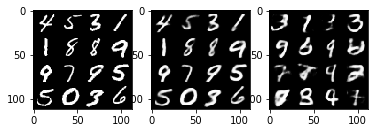

<Epoch:809/1000, Step:140/545>total_loss: 95.8817, kl_loss: 23.6936, recon_loss: 72.1882
<Epoch:810/1000, Step:095/545>total_loss: 96.0610, kl_loss: 23.8544, recon_loss: 72.2066
<Epoch:811/1000, Step:050/545>total_loss: 98.0553, kl_loss: 24.0814, recon_loss: 73.9739
<Epoch:812/1000, Step:005/545>total_loss: 95.8842, kl_loss: 23.6893, recon_loss: 72.1949
<Epoch:812/1000, Step:505/545>total_loss: 97.4450, kl_loss: 23.7189, recon_loss: 73.7261


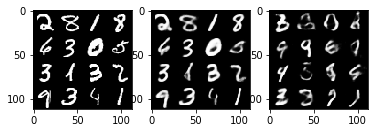

<Epoch:813/1000, Step:460/545>total_loss: 98.5060, kl_loss: 24.1735, recon_loss: 74.3325
<Epoch:814/1000, Step:415/545>total_loss: 96.5384, kl_loss: 24.2049, recon_loss: 72.3335
<Epoch:815/1000, Step:370/545>total_loss: 98.5506, kl_loss: 24.0735, recon_loss: 74.4772
<Epoch:816/1000, Step:325/545>total_loss: 93.3508, kl_loss: 23.7368, recon_loss: 69.6140
<Epoch:817/1000, Step:280/545>total_loss: 93.6357, kl_loss: 23.1701, recon_loss: 70.4656


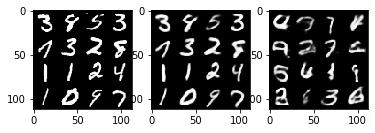

<Epoch:818/1000, Step:235/545>total_loss: 101.0458, kl_loss: 24.5255, recon_loss: 76.5203
<Epoch:819/1000, Step:190/545>total_loss: 97.6230, kl_loss: 23.9372, recon_loss: 73.6858
<Epoch:820/1000, Step:145/545>total_loss: 99.3250, kl_loss: 24.3902, recon_loss: 74.9347
<Epoch:821/1000, Step:100/545>total_loss: 95.6842, kl_loss: 23.8758, recon_loss: 71.8083
<Epoch:822/1000, Step:055/545>total_loss: 94.3417, kl_loss: 23.6124, recon_loss: 70.7293


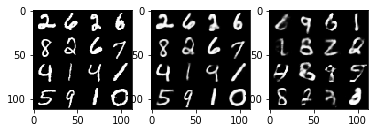

<Epoch:823/1000, Step:010/545>total_loss: 95.3958, kl_loss: 23.9030, recon_loss: 71.4928
<Epoch:823/1000, Step:510/545>total_loss: 98.1761, kl_loss: 24.1789, recon_loss: 73.9972
<Epoch:824/1000, Step:465/545>total_loss: 96.9349, kl_loss: 23.7315, recon_loss: 73.2034
<Epoch:825/1000, Step:420/545>total_loss: 97.9753, kl_loss: 24.3347, recon_loss: 73.6406
<Epoch:826/1000, Step:375/545>total_loss: 98.4824, kl_loss: 24.1637, recon_loss: 74.3187


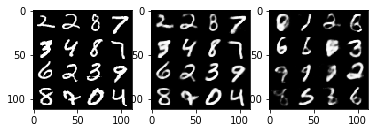

<Epoch:827/1000, Step:330/545>total_loss: 95.5053, kl_loss: 23.9628, recon_loss: 71.5425
<Epoch:828/1000, Step:285/545>total_loss: 98.3895, kl_loss: 24.5670, recon_loss: 73.8225
<Epoch:829/1000, Step:240/545>total_loss: 94.9001, kl_loss: 23.8166, recon_loss: 71.0835
<Epoch:830/1000, Step:195/545>total_loss: 99.3814, kl_loss: 24.4274, recon_loss: 74.9540
<Epoch:831/1000, Step:150/545>total_loss: 99.2939, kl_loss: 24.5609, recon_loss: 74.7330


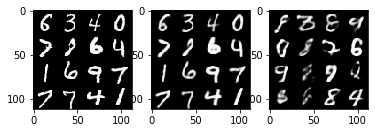

<Epoch:832/1000, Step:105/545>total_loss: 97.1059, kl_loss: 23.8952, recon_loss: 73.2107
<Epoch:833/1000, Step:060/545>total_loss: 100.0106, kl_loss: 24.9311, recon_loss: 75.0795
<Epoch:834/1000, Step:015/545>total_loss: 96.0662, kl_loss: 24.0998, recon_loss: 71.9665
<Epoch:834/1000, Step:515/545>total_loss: 97.2089, kl_loss: 23.8590, recon_loss: 73.3499
<Epoch:835/1000, Step:470/545>total_loss: 95.4216, kl_loss: 23.7816, recon_loss: 71.6400


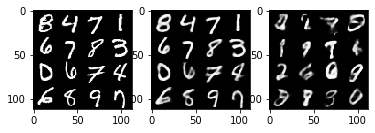

<Epoch:836/1000, Step:425/545>total_loss: 93.1949, kl_loss: 23.2132, recon_loss: 69.9816
<Epoch:837/1000, Step:380/545>total_loss: 98.6743, kl_loss: 24.5441, recon_loss: 74.1302
<Epoch:838/1000, Step:335/545>total_loss: 97.7016, kl_loss: 24.1967, recon_loss: 73.5050
<Epoch:839/1000, Step:290/545>total_loss: 99.4063, kl_loss: 24.3128, recon_loss: 75.0935
<Epoch:840/1000, Step:245/545>total_loss: 96.8422, kl_loss: 24.4507, recon_loss: 72.3915


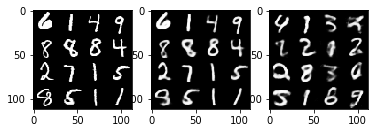

<Epoch:841/1000, Step:200/545>total_loss: 97.1491, kl_loss: 23.9974, recon_loss: 73.1516
<Epoch:842/1000, Step:155/545>total_loss: 94.7073, kl_loss: 23.6089, recon_loss: 71.0984
<Epoch:843/1000, Step:110/545>total_loss: 96.9636, kl_loss: 23.9175, recon_loss: 73.0461
<Epoch:844/1000, Step:065/545>total_loss: 99.6990, kl_loss: 24.2934, recon_loss: 75.4056
<Epoch:845/1000, Step:020/545>total_loss: 99.0494, kl_loss: 24.5171, recon_loss: 74.5323


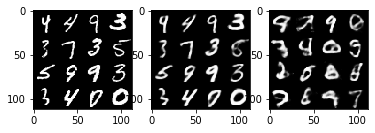

<Epoch:845/1000, Step:520/545>total_loss: 96.3487, kl_loss: 24.1688, recon_loss: 72.1799
<Epoch:846/1000, Step:475/545>total_loss: 96.4929, kl_loss: 24.1474, recon_loss: 72.3455
<Epoch:847/1000, Step:430/545>total_loss: 98.8802, kl_loss: 24.6472, recon_loss: 74.2330
<Epoch:848/1000, Step:385/545>total_loss: 97.8391, kl_loss: 24.2937, recon_loss: 73.5453
<Epoch:849/1000, Step:340/545>total_loss: 98.9998, kl_loss: 24.4807, recon_loss: 74.5191


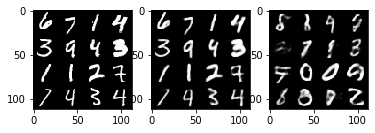

<Epoch:850/1000, Step:295/545>total_loss: 97.1503, kl_loss: 23.9621, recon_loss: 73.1882
<Epoch:851/1000, Step:250/545>total_loss: 97.3285, kl_loss: 24.4377, recon_loss: 72.8908
<Epoch:852/1000, Step:205/545>total_loss: 100.2508, kl_loss: 24.3539, recon_loss: 75.8969
<Epoch:853/1000, Step:160/545>total_loss: 94.7484, kl_loss: 23.5958, recon_loss: 71.1526
<Epoch:854/1000, Step:115/545>total_loss: 100.9278, kl_loss: 24.6333, recon_loss: 76.2946


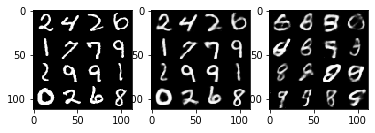

<Epoch:855/1000, Step:070/545>total_loss: 100.3120, kl_loss: 24.6858, recon_loss: 75.6262
<Epoch:856/1000, Step:025/545>total_loss: 97.8986, kl_loss: 24.2695, recon_loss: 73.6291
<Epoch:856/1000, Step:525/545>total_loss: 96.3300, kl_loss: 24.4010, recon_loss: 71.9290
<Epoch:857/1000, Step:480/545>total_loss: 99.3976, kl_loss: 24.5201, recon_loss: 74.8775
<Epoch:858/1000, Step:435/545>total_loss: 98.6368, kl_loss: 24.3357, recon_loss: 74.3011


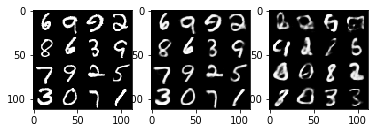

<Epoch:859/1000, Step:390/545>total_loss: 95.6979, kl_loss: 24.1565, recon_loss: 71.5414
<Epoch:860/1000, Step:345/545>total_loss: 100.5474, kl_loss: 24.2214, recon_loss: 76.3260
<Epoch:861/1000, Step:300/545>total_loss: 95.0275, kl_loss: 23.7000, recon_loss: 71.3275
<Epoch:862/1000, Step:255/545>total_loss: 95.9081, kl_loss: 23.6212, recon_loss: 72.2868
<Epoch:863/1000, Step:210/545>total_loss: 92.2610, kl_loss: 23.5136, recon_loss: 68.7475


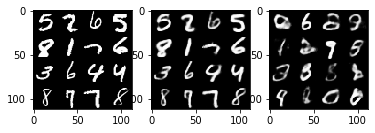

<Epoch:864/1000, Step:165/545>total_loss: 96.9384, kl_loss: 23.8864, recon_loss: 73.0520
<Epoch:865/1000, Step:120/545>total_loss: 99.4320, kl_loss: 24.2901, recon_loss: 75.1419
<Epoch:866/1000, Step:075/545>total_loss: 97.4884, kl_loss: 24.0610, recon_loss: 73.4274
<Epoch:867/1000, Step:030/545>total_loss: 96.9779, kl_loss: 23.7567, recon_loss: 73.2213
<Epoch:867/1000, Step:530/545>total_loss: 99.6224, kl_loss: 24.2113, recon_loss: 75.4111


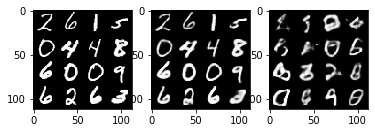

<Epoch:868/1000, Step:485/545>total_loss: 98.4466, kl_loss: 24.4258, recon_loss: 74.0208
<Epoch:869/1000, Step:440/545>total_loss: 100.7595, kl_loss: 24.7930, recon_loss: 75.9665
<Epoch:870/1000, Step:395/545>total_loss: 93.4568, kl_loss: 23.6139, recon_loss: 69.8429
<Epoch:871/1000, Step:350/545>total_loss: 99.6302, kl_loss: 24.6851, recon_loss: 74.9451
<Epoch:872/1000, Step:305/545>total_loss: 102.8448, kl_loss: 24.8594, recon_loss: 77.9855


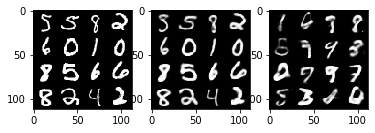

<Epoch:873/1000, Step:260/545>total_loss: 97.8649, kl_loss: 24.1293, recon_loss: 73.7355
<Epoch:874/1000, Step:215/545>total_loss: 98.5676, kl_loss: 24.5058, recon_loss: 74.0619
<Epoch:875/1000, Step:170/545>total_loss: 97.4227, kl_loss: 23.8565, recon_loss: 73.5662
<Epoch:876/1000, Step:125/545>total_loss: 98.9145, kl_loss: 24.2156, recon_loss: 74.6989
<Epoch:877/1000, Step:080/545>total_loss: 95.4408, kl_loss: 23.7449, recon_loss: 71.6959


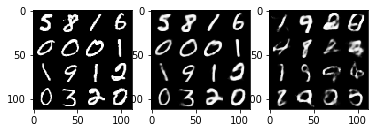

<Epoch:878/1000, Step:035/545>total_loss: 93.9860, kl_loss: 23.6262, recon_loss: 70.3598
<Epoch:878/1000, Step:535/545>total_loss: 98.0765, kl_loss: 24.0978, recon_loss: 73.9787
<Epoch:879/1000, Step:490/545>total_loss: 97.5112, kl_loss: 24.3499, recon_loss: 73.1613
<Epoch:880/1000, Step:445/545>total_loss: 97.7218, kl_loss: 23.9634, recon_loss: 73.7583
<Epoch:881/1000, Step:400/545>total_loss: 100.7004, kl_loss: 24.5354, recon_loss: 76.1650


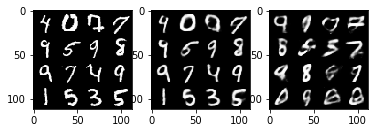

<Epoch:882/1000, Step:355/545>total_loss: 96.6678, kl_loss: 24.3709, recon_loss: 72.2970
<Epoch:883/1000, Step:310/545>total_loss: 96.1445, kl_loss: 24.1350, recon_loss: 72.0095
<Epoch:884/1000, Step:265/545>total_loss: 98.8638, kl_loss: 24.7001, recon_loss: 74.1637
<Epoch:885/1000, Step:220/545>total_loss: 99.0603, kl_loss: 24.4676, recon_loss: 74.5927
<Epoch:886/1000, Step:175/545>total_loss: 97.2912, kl_loss: 23.7229, recon_loss: 73.5683


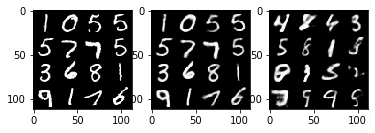

<Epoch:887/1000, Step:130/545>total_loss: 97.5364, kl_loss: 24.4458, recon_loss: 73.0907
<Epoch:888/1000, Step:085/545>total_loss: 101.6633, kl_loss: 25.1511, recon_loss: 76.5122
<Epoch:889/1000, Step:040/545>total_loss: 98.2586, kl_loss: 23.7732, recon_loss: 74.4854
<Epoch:889/1000, Step:540/545>total_loss: 97.7906, kl_loss: 23.7502, recon_loss: 74.0404
<Epoch:890/1000, Step:495/545>total_loss: 95.2166, kl_loss: 23.7596, recon_loss: 71.4569


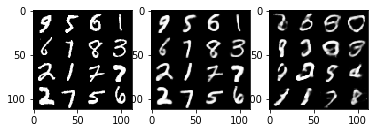

<Epoch:891/1000, Step:450/545>total_loss: 96.9794, kl_loss: 24.3777, recon_loss: 72.6017
<Epoch:892/1000, Step:405/545>total_loss: 94.0541, kl_loss: 23.3002, recon_loss: 70.7539
<Epoch:893/1000, Step:360/545>total_loss: 96.9939, kl_loss: 23.5415, recon_loss: 73.4524
<Epoch:894/1000, Step:315/545>total_loss: 100.0101, kl_loss: 24.2418, recon_loss: 75.7683
<Epoch:895/1000, Step:270/545>total_loss: 95.9006, kl_loss: 23.8820, recon_loss: 72.0186


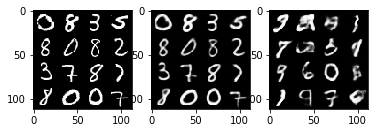

<Epoch:896/1000, Step:225/545>total_loss: 100.1780, kl_loss: 24.2904, recon_loss: 75.8876
<Epoch:897/1000, Step:180/545>total_loss: 98.6543, kl_loss: 24.2233, recon_loss: 74.4310
<Epoch:898/1000, Step:135/545>total_loss: 99.7071, kl_loss: 24.5001, recon_loss: 75.2070
<Epoch:899/1000, Step:090/545>total_loss: 97.5948, kl_loss: 24.2439, recon_loss: 73.3509
<Epoch:900/1000, Step:045/545>total_loss: 97.6650, kl_loss: 24.1554, recon_loss: 73.5096


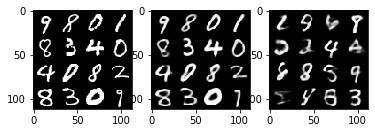

<Epoch:900/1000, Step:545/545>total_loss: 93.3616, kl_loss: 23.5188, recon_loss: 69.8428
<Epoch:901/1000, Step:500/545>total_loss: 98.3980, kl_loss: 23.9690, recon_loss: 74.4291
<Epoch:902/1000, Step:455/545>total_loss: 92.3959, kl_loss: 23.3386, recon_loss: 69.0573
<Epoch:903/1000, Step:410/545>total_loss: 95.6791, kl_loss: 23.8227, recon_loss: 71.8564
<Epoch:904/1000, Step:365/545>total_loss: 100.5712, kl_loss: 24.5011, recon_loss: 76.0701


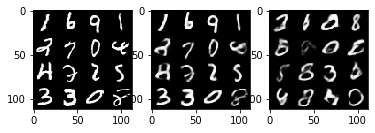

<Epoch:905/1000, Step:320/545>total_loss: 94.8192, kl_loss: 23.8728, recon_loss: 70.9464
<Epoch:906/1000, Step:275/545>total_loss: 98.2823, kl_loss: 23.8806, recon_loss: 74.4016
<Epoch:907/1000, Step:230/545>total_loss: 98.7841, kl_loss: 24.3792, recon_loss: 74.4049
<Epoch:908/1000, Step:185/545>total_loss: 97.6969, kl_loss: 23.9003, recon_loss: 73.7966
<Epoch:909/1000, Step:140/545>total_loss: 100.4052, kl_loss: 24.8829, recon_loss: 75.5224


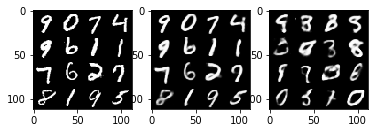

<Epoch:910/1000, Step:095/545>total_loss: 97.2727, kl_loss: 24.2598, recon_loss: 73.0129
<Epoch:911/1000, Step:050/545>total_loss: 96.1111, kl_loss: 24.1768, recon_loss: 71.9343
<Epoch:912/1000, Step:005/545>total_loss: 97.6444, kl_loss: 24.3218, recon_loss: 73.3225
<Epoch:912/1000, Step:505/545>total_loss: 100.1495, kl_loss: 23.9663, recon_loss: 76.1832
<Epoch:913/1000, Step:460/545>total_loss: 95.2401, kl_loss: 23.9371, recon_loss: 71.3030


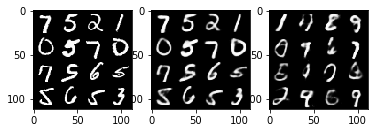

<Epoch:914/1000, Step:415/545>total_loss: 99.1537, kl_loss: 24.1345, recon_loss: 75.0192
<Epoch:915/1000, Step:370/545>total_loss: 100.4375, kl_loss: 24.5676, recon_loss: 75.8699
<Epoch:916/1000, Step:325/545>total_loss: 99.3921, kl_loss: 24.7897, recon_loss: 74.6023
<Epoch:917/1000, Step:280/545>total_loss: 96.6340, kl_loss: 24.1038, recon_loss: 72.5302
<Epoch:918/1000, Step:235/545>total_loss: 97.6702, kl_loss: 24.3052, recon_loss: 73.3649


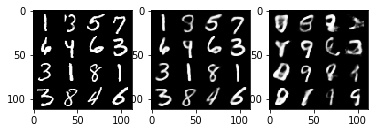

<Epoch:919/1000, Step:190/545>total_loss: 96.2971, kl_loss: 24.0350, recon_loss: 72.2621
<Epoch:920/1000, Step:145/545>total_loss: 98.9035, kl_loss: 23.9773, recon_loss: 74.9263
<Epoch:921/1000, Step:100/545>total_loss: 94.0328, kl_loss: 23.4774, recon_loss: 70.5555
<Epoch:922/1000, Step:055/545>total_loss: 96.6499, kl_loss: 24.0563, recon_loss: 72.5936
<Epoch:923/1000, Step:010/545>total_loss: 98.5789, kl_loss: 24.3635, recon_loss: 74.2154


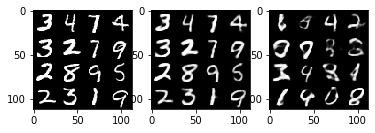

<Epoch:923/1000, Step:510/545>total_loss: 97.3403, kl_loss: 24.2153, recon_loss: 73.1250
<Epoch:924/1000, Step:465/545>total_loss: 96.6245, kl_loss: 24.0232, recon_loss: 72.6013
<Epoch:925/1000, Step:420/545>total_loss: 99.9358, kl_loss: 24.5196, recon_loss: 75.4162
<Epoch:926/1000, Step:375/545>total_loss: 94.6223, kl_loss: 23.5638, recon_loss: 71.0585
<Epoch:927/1000, Step:330/545>total_loss: 95.4892, kl_loss: 24.0007, recon_loss: 71.4885


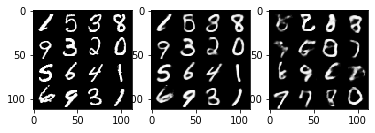

<Epoch:928/1000, Step:285/545>total_loss: 96.0789, kl_loss: 23.5832, recon_loss: 72.4957
<Epoch:929/1000, Step:240/545>total_loss: 96.2760, kl_loss: 24.1869, recon_loss: 72.0891
<Epoch:930/1000, Step:195/545>total_loss: 97.1244, kl_loss: 24.0185, recon_loss: 73.1059
<Epoch:931/1000, Step:150/545>total_loss: 96.3263, kl_loss: 24.1407, recon_loss: 72.1856
<Epoch:932/1000, Step:105/545>total_loss: 97.1135, kl_loss: 23.8037, recon_loss: 73.3098


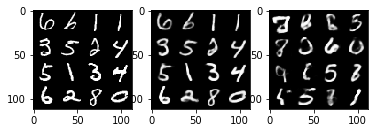

<Epoch:933/1000, Step:060/545>total_loss: 101.7625, kl_loss: 24.8834, recon_loss: 76.8791
<Epoch:934/1000, Step:015/545>total_loss: 96.7690, kl_loss: 24.1447, recon_loss: 72.6243
<Epoch:934/1000, Step:515/545>total_loss: 95.8669, kl_loss: 23.6134, recon_loss: 72.2535
<Epoch:935/1000, Step:470/545>total_loss: 99.8944, kl_loss: 24.7312, recon_loss: 75.1633
<Epoch:936/1000, Step:425/545>total_loss: 99.6071, kl_loss: 24.5674, recon_loss: 75.0397


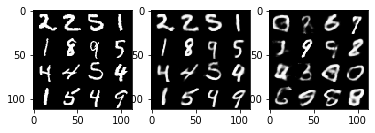

<Epoch:937/1000, Step:380/545>total_loss: 97.1293, kl_loss: 23.9568, recon_loss: 73.1726
<Epoch:938/1000, Step:335/545>total_loss: 96.4745, kl_loss: 23.8462, recon_loss: 72.6283
<Epoch:939/1000, Step:290/545>total_loss: 98.8456, kl_loss: 24.2481, recon_loss: 74.5975
<Epoch:940/1000, Step:245/545>total_loss: 98.4136, kl_loss: 24.3500, recon_loss: 74.0636
<Epoch:941/1000, Step:200/545>total_loss: 95.0896, kl_loss: 23.9693, recon_loss: 71.1203


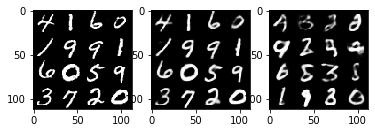

<Epoch:942/1000, Step:155/545>total_loss: 95.8988, kl_loss: 23.6110, recon_loss: 72.2879
<Epoch:943/1000, Step:110/545>total_loss: 95.6893, kl_loss: 24.0389, recon_loss: 71.6504
<Epoch:944/1000, Step:065/545>total_loss: 99.1189, kl_loss: 24.2947, recon_loss: 74.8242
<Epoch:945/1000, Step:020/545>total_loss: 98.6947, kl_loss: 24.6638, recon_loss: 74.0309
<Epoch:945/1000, Step:520/545>total_loss: 100.7471, kl_loss: 24.6079, recon_loss: 76.1393


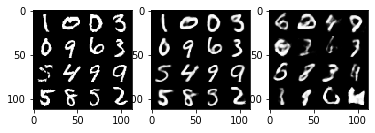

<Epoch:946/1000, Step:475/545>total_loss: 99.2666, kl_loss: 24.3169, recon_loss: 74.9497
<Epoch:947/1000, Step:430/545>total_loss: 98.3878, kl_loss: 24.4740, recon_loss: 73.9138
<Epoch:948/1000, Step:385/545>total_loss: 94.6930, kl_loss: 24.1563, recon_loss: 70.5367
<Epoch:949/1000, Step:340/545>total_loss: 102.6745, kl_loss: 24.6526, recon_loss: 78.0218
<Epoch:950/1000, Step:295/545>total_loss: 98.8354, kl_loss: 24.2538, recon_loss: 74.5816


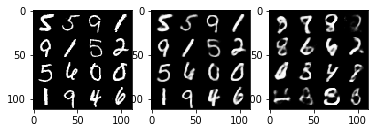

<Epoch:951/1000, Step:250/545>total_loss: 97.5059, kl_loss: 24.2849, recon_loss: 73.2210
<Epoch:952/1000, Step:205/545>total_loss: 98.4545, kl_loss: 24.0772, recon_loss: 74.3773
<Epoch:953/1000, Step:160/545>total_loss: 98.6780, kl_loss: 24.3573, recon_loss: 74.3207
<Epoch:954/1000, Step:115/545>total_loss: 97.4795, kl_loss: 24.1411, recon_loss: 73.3384
<Epoch:955/1000, Step:070/545>total_loss: 98.4277, kl_loss: 24.5406, recon_loss: 73.8871


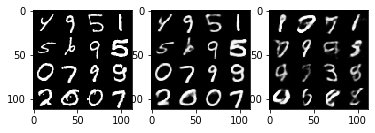

<Epoch:956/1000, Step:025/545>total_loss: 94.4385, kl_loss: 23.6698, recon_loss: 70.7687
<Epoch:956/1000, Step:525/545>total_loss: 95.5368, kl_loss: 23.4642, recon_loss: 72.0726
<Epoch:957/1000, Step:480/545>total_loss: 97.4317, kl_loss: 23.8954, recon_loss: 73.5363
<Epoch:958/1000, Step:435/545>total_loss: 99.0322, kl_loss: 24.5138, recon_loss: 74.5184
<Epoch:959/1000, Step:390/545>total_loss: 94.5234, kl_loss: 23.6627, recon_loss: 70.8607


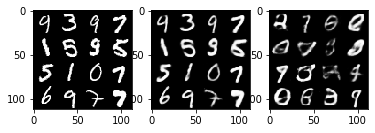

<Epoch:960/1000, Step:345/545>total_loss: 93.9269, kl_loss: 23.9162, recon_loss: 70.0107
<Epoch:961/1000, Step:300/545>total_loss: 97.0255, kl_loss: 24.6109, recon_loss: 72.4145
<Epoch:962/1000, Step:255/545>total_loss: 100.4081, kl_loss: 24.4355, recon_loss: 75.9726
<Epoch:963/1000, Step:210/545>total_loss: 97.7185, kl_loss: 24.0399, recon_loss: 73.6786
<Epoch:964/1000, Step:165/545>total_loss: 100.1990, kl_loss: 24.3817, recon_loss: 75.8173


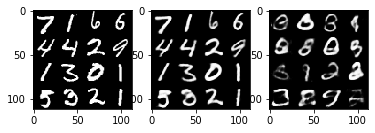

<Epoch:965/1000, Step:120/545>total_loss: 99.1535, kl_loss: 24.8784, recon_loss: 74.2751
<Epoch:966/1000, Step:075/545>total_loss: 95.6275, kl_loss: 23.9049, recon_loss: 71.7227
<Epoch:967/1000, Step:030/545>total_loss: 91.0991, kl_loss: 23.0834, recon_loss: 68.0157
<Epoch:967/1000, Step:530/545>total_loss: 93.2514, kl_loss: 23.2213, recon_loss: 70.0302
<Epoch:968/1000, Step:485/545>total_loss: 97.7939, kl_loss: 24.3962, recon_loss: 73.3977


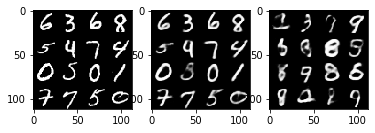

<Epoch:969/1000, Step:440/545>total_loss: 95.1384, kl_loss: 23.8943, recon_loss: 71.2441
<Epoch:970/1000, Step:395/545>total_loss: 97.2682, kl_loss: 23.8804, recon_loss: 73.3879
<Epoch:971/1000, Step:350/545>total_loss: 100.4769, kl_loss: 24.6968, recon_loss: 75.7801
<Epoch:972/1000, Step:305/545>total_loss: 99.7221, kl_loss: 24.1502, recon_loss: 75.5719
<Epoch:973/1000, Step:260/545>total_loss: 96.3402, kl_loss: 24.2891, recon_loss: 72.0511


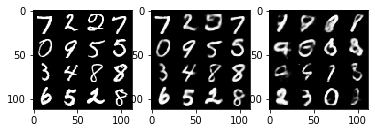

<Epoch:974/1000, Step:215/545>total_loss: 99.2496, kl_loss: 24.3566, recon_loss: 74.8931
<Epoch:975/1000, Step:170/545>total_loss: 94.8864, kl_loss: 23.7995, recon_loss: 71.0868
<Epoch:976/1000, Step:125/545>total_loss: 98.2140, kl_loss: 23.9967, recon_loss: 74.2173
<Epoch:977/1000, Step:080/545>total_loss: 95.7569, kl_loss: 23.5809, recon_loss: 72.1760
<Epoch:978/1000, Step:035/545>total_loss: 97.9118, kl_loss: 23.9510, recon_loss: 73.9608


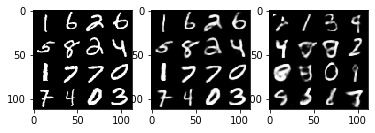

<Epoch:978/1000, Step:535/545>total_loss: 98.6018, kl_loss: 23.9347, recon_loss: 74.6672
<Epoch:979/1000, Step:490/545>total_loss: 97.9504, kl_loss: 24.1393, recon_loss: 73.8111
<Epoch:980/1000, Step:445/545>total_loss: 96.6926, kl_loss: 23.9922, recon_loss: 72.7003
<Epoch:981/1000, Step:400/545>total_loss: 99.6307, kl_loss: 24.8250, recon_loss: 74.8056
<Epoch:982/1000, Step:355/545>total_loss: 97.2402, kl_loss: 24.3529, recon_loss: 72.8873


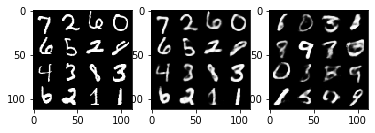

<Epoch:983/1000, Step:310/545>total_loss: 98.6084, kl_loss: 24.4602, recon_loss: 74.1482
<Epoch:984/1000, Step:265/545>total_loss: 97.0696, kl_loss: 23.4741, recon_loss: 73.5954
<Epoch:985/1000, Step:220/545>total_loss: 97.3077, kl_loss: 24.2989, recon_loss: 73.0088
<Epoch:986/1000, Step:175/545>total_loss: 96.3872, kl_loss: 23.7659, recon_loss: 72.6213
<Epoch:987/1000, Step:130/545>total_loss: 99.6889, kl_loss: 24.1311, recon_loss: 75.5577


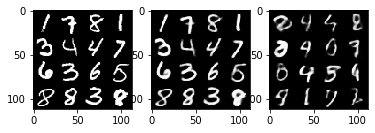

<Epoch:988/1000, Step:085/545>total_loss: 96.3099, kl_loss: 24.2564, recon_loss: 72.0535
<Epoch:989/1000, Step:040/545>total_loss: 97.4677, kl_loss: 24.2854, recon_loss: 73.1822
<Epoch:989/1000, Step:540/545>total_loss: 97.9263, kl_loss: 23.9130, recon_loss: 74.0133
<Epoch:990/1000, Step:495/545>total_loss: 98.9742, kl_loss: 24.2091, recon_loss: 74.7652
<Epoch:991/1000, Step:450/545>total_loss: 95.0510, kl_loss: 23.7206, recon_loss: 71.3303


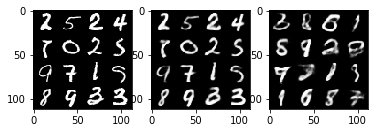

<Epoch:992/1000, Step:405/545>total_loss: 95.6740, kl_loss: 23.7817, recon_loss: 71.8922
<Epoch:993/1000, Step:360/545>total_loss: 97.9647, kl_loss: 24.2080, recon_loss: 73.7567
<Epoch:994/1000, Step:315/545>total_loss: 96.7955, kl_loss: 23.9476, recon_loss: 72.8478
<Epoch:995/1000, Step:270/545>total_loss: 97.6068, kl_loss: 24.0430, recon_loss: 73.5638
<Epoch:996/1000, Step:225/545>total_loss: 95.8537, kl_loss: 23.7273, recon_loss: 72.1264


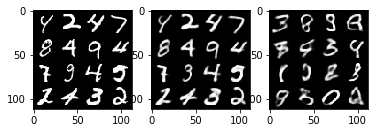

<Epoch:997/1000, Step:180/545>total_loss: 98.8909, kl_loss: 24.1587, recon_loss: 74.7322
<Epoch:998/1000, Step:135/545>total_loss: 94.7948, kl_loss: 23.9737, recon_loss: 70.8211
<Epoch:999/1000, Step:090/545>total_loss: 96.6245, kl_loss: 23.8729, recon_loss: 72.7516
<Epoch:1000/1000, Step:045/545>total_loss: 96.6731, kl_loss: 24.4898, recon_loss: 72.1833
<Epoch:1000/1000, Step:545/545>total_loss: 93.7542, kl_loss: 23.6932, recon_loss: 70.0610


In [107]:
x = tf.placeholder(tf.float32, [None, output_size, output_size, img_channel])

# encoding
mean, logvar = encoder(x, img_dim=output_size*output_size*img_channel, latent_dim=latent_channel)

#reparametrizing
eps = tf.placeholder(tf.float32, [None, latent_channel])
############## ToDo ##############
z = mean + tf.exp(logvar / 2) * eps
##################################

#decoding
x_hat = decoder(z, latent_dim=latent_channel, img_dim=output_size*output_size*img_channel)
x_hat = tf.reshape(x_hat, [batch_size, output_size, output_size, img_channel])

#geneartion
x_new = decoder(eps, latent_dim=latent_channel, img_dim=output_size*output_size*img_channel, reuse=True)
x_new = tf.reshape(x_new, [batch_size, output_size, output_size, img_channel])

############## ToDo ##############
#D_KL(Q(z|X) || P(z|X))
kl_loss = 0.5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1.0 - logvar, axis=1)
kl_loss = tf.reduce_mean(kl_loss)
#E[log P(X|z)]
#convert back x_hat to logits
_epsilon = tf.convert_to_tensor(1e-8, dtype=tf.float32)
logits = tf.clip_by_value(x_hat, _epsilon, 1 - _epsilon)
logits = tf.log(logits / (1 - logits))
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=x), axis=[1,2,3])
recon_loss = tf.reduce_mean(recon_loss)
total_loss = kl_loss + recon_loss
##################################

optim = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(config=config) as sess:
    sess.run(init)
    step = 0
    
    for e in range(EPOCH):
        for b in range(len(data_array)//batch_size - 1):
            step += 1
            
            img, _ = getNext_batch(data_array, data_y, b, batch_size)
            batch_eps = np.random.randn(batch_size, latent_channel)
            
            feed_dict = {x: img, eps: batch_eps}
            _ = sess.run(optim, feed_dict=feed_dict)
            
            if step % loss_step == 0:
                total, kl, recon = sess.run([total_loss, kl_loss, recon_loss], feed_dict=feed_dict)
                print('<Epoch:%d/%d, Step:%03d/%d>total_loss: %.4f, kl_loss: %.4f, recon_loss: %.4f'
                      %(e+1, EPOCH, b+1, len(data_array)//batch_size-1, total, kl, recon))
                
            if np.mod(step, display_step) == 1:
                recon_imgs, gen_imgs = sess.run([x_hat, x_new], feed_dict=feed_dict)
                recon_imgs = recon_imgs[:16, :, :, :]
                gen_imgs = gen_imgs[:16, :, :, :]
                plt.subplot(1, 3, 1)
                imgplot1 = show_images(img[:16, :, :, :], [4, 4])
                plt.subplot(1, 3, 2)
                imgplot2= show_images(recon_imgs, [4, 4])
                plt.subplot(1, 3, 3)
                imgplot3 = show_images(gen_imgs, [4, 4])
                plt.show()
        
        idx_list = np.arange(len(data_array))
        np.random.shuffle(idx_list)
        data_array = data_array[idx_list]
        data_y = data_y[idx_list]